# Trabajo final mineria

### por: Iñaki Luque y Ander Ros

## Indice
- [Librerias:](#Librerías-necesarias)
- [Selección del problema:](#Selección-del-problema-y-motivación)
- [Lectura Datos:](#Lectura-de-datos)
- [Distribución Area:](#Distribución-de-la-variable-de-salida-Área)
- [Cambio a clasificación:](#Cambio-a-problema-tipo-clasificacion)
- [Valores nulos:](#Comprobación-de-valores-nulos)
- [Tipo variables:](#Ver-tipo-variables)
- [Transformación variables numéricas:](#Transformación-variables-categóricas-a-numéricas)
- [Detección de outliers:](#Deteccion-de-outliers)
     - [IQR Percentile:](#IQR-percentile)
     - [Distribución variables tras deteccin outliers](#Distribución-variables-tras-detección-de-outliers)
- [Análisis de correlaciones](#Analisis-de-correlaciones)
- [Análisis del área quemada por meses](#Análisis-del-área-quemada-por-meses)
- [Análisis del área quemada por días](#Análisis-del-área-quemada-por-días)
- [Primera prueba:](#Pipeline-KNN:-primeras-pruebas-para-ver-el-funcionamiento-del-modelo)
- [Preparación datos:](#Preparación-de-datos-a-entrenar,-con-los-cambios-descritos-previamente.)
- [Selección de variables:](#Selección-de-variables)
    - [Filtro ANOVA: Sin DC](#FILTRO-ANOVA:-Sin-DC)
    - [Filtro ANOVA: con DC](#FILTRO-ANOVA:-con-DC)
    - [Métodos basados en wrappers](#MÉTODOS-BASADOS-EN-WRAPPERS)
        - [RFE: sin DC](#RFE:-sin-DC)
        - [RFE: con DC](#RFE:-con-DC)
        - [Sequential forward selection](#SEQUENTIAL-FORWARD-SELECTION)
        - [Sequential backward selection](#SEQUENTIAL-BACKWARD-SELECTION)
        - [RFECV](#RFECV)
- [Predicciones:](#PREDICCIONES)
    - [KNN:](#PREDICCION-ANOVA+KNN-CON-GRIDSEARCH)
    - [Regresión logística](#Regresión-logística)
    - [SVM](#SVM)
    - [Decision tree](#Decision-tree)
- [Métricas de rendimiento: ](#MÉTRICAS-DE-RENDIMIENTO)
    - [Matrices de confusión: ](#Matrices-de-confusión)
    - [Curva ROC: ](#Curva-ROC)
- [Selección de instancias: ](#Seleccion-de-instancias:-COMPROBAMOS-QUE-NO-MEJORAN-NUESTRO-MODELO.-No-lo-hemos-acabado-implementandolo)
- [Conclusiones finales: ](#Conclusiones-finales)


## Librerías necesarias

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection
import category_encoders as ce
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import feature_selection
from scipy import stats
from sklearn import tree
from matplotlib.colors import ListedColormap
from sklearn import metrics

## Selección del problema y motivación

Hemos elegido un dataset que predice el área afectada por incendios forestales.

## Lectura de datos

In [2]:
datos = pd.read_csv("forestfires.csv",na_values = '?')
variablesAtEntrada = list(datos.columns)
variablesAtEntrada.pop()
variablesAtSalida = ['area']
X = pd.DataFrame(datos[variablesAtEntrada].copy())
y = pd.DataFrame(datos[variablesAtSalida].copy())
y = y.values
datos.head(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Informacion a priori del dataframe

In [3]:
X.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000


## Distribución de la variable de salida Área

(array([508.,   6.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([   0.   ,  109.084,  218.168,  327.252,  436.336,  545.42 ,
         654.504,  763.588,  872.672,  981.756, 1090.84 ]),
 <BarContainer object of 10 artists>)

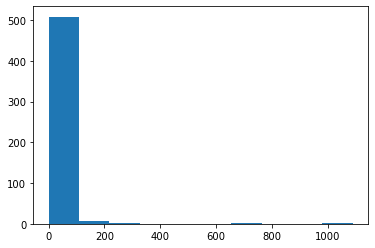

In [4]:
plt.hist(y)

Podemos ver que la distribución del área quemada esta muy sesgada hacia el 0, por lo que hemos decidido cambiar el tipo de problema a clasificación. Donde si no hay superficie quemada la clase será 0 y si hay área quemada pertenecerá a la clase 1.

## Cambio a problema tipo clasificacion

In [5]:
yClass = y.copy()
yClass[yClass>0] = 1

(array([247.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 270.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

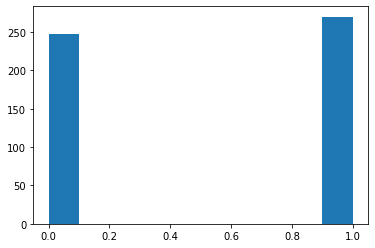

In [6]:
plt.hist(yClass)

Las clases ahora están balanceadas. Por lo que no vamos a tener que hacer uso de técnicas de Over-sampling ni de Under-Sampling

### MODIFICACION AREA REGRESIÓN: SI QUISIEREAMOS PLANTEAR EL PROBLEMA PARA REGRESIÓN

(array([275.,  61.,  59.,  54.,  29.,  21.,   9.,   6.,   1.,   2.]),
 array([0.        , 0.69956196, 1.39912393, 2.09868589, 2.79824785,
        3.49780981, 4.19737178, 4.89693374, 5.5964957 , 6.29605766,
        6.99561963]),
 <BarContainer object of 10 artists>)

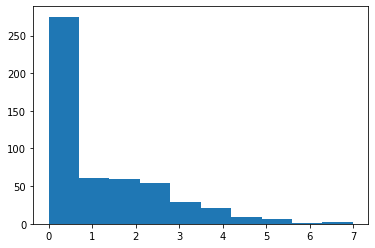

In [7]:
yReg = y.copy()
yReg = np.log(yReg+1)
plt.hist(yReg)

En el caso de que queramos realizar el problema para regresión transformaríamos la variable usando una función logarítmica. Como podemos comprobar se redistribuye mejor los valores de la variable

## Comprobación de valores nulos

In [8]:
datos[datos.isnull().any(axis=1)]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area


Podemos comprobar que no hay valores nulos en nuestro dataset. No va a ser necesario aplicar ninguna técnica de imputación.

## Ver tipo variables

In [9]:
variables_categoricas = X.columns[X.dtypes == object].tolist()
variables_numericas = X.columns[X.dtypes != object].tolist()
print('Variables categóricas : ',variables_categoricas)
print('Variables numéricas : ', variables_numericas)
y = yClass

Variables categóricas :  ['month', 'day']
Variables numéricas :  ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']


#### Hacemos una copia de la X para hacer pruebas

In [10]:
Xwork = X.copy()

### Transformación variables categóricas a numéricas

Hemos usado codificación ordinal para los meses y los días, ya que estas variables siguen un orden. Lo mapeamos para poner el orden con que el vamos a trabajar.

In [11]:
mapping = [
    {
        'col':'month',
        'mapping':{
            'jan':0,
            'feb':1,
            'mar':2,
            'apr':3,
            'may':4,
            'jun':5,
            'jul':6,
            'aug':7,
            'sep':8,
            'oct':9,
            'nov':10,
            'dec':11
        }
    },
    {
        'col':'day',
        'mapping':{
            'mon':0,
            'tue':1,
            'wed':2,
            'thu':3,
            'fri':4,
            'sat':5,
            'sun':6
        }
    }
]

ordinal = ce.ordinal.OrdinalEncoder(mapping=mapping)
Xwork=ordinal.fit_transform(Xwork)
Xwork

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7,5,2,4,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,9,1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,9,5,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,2,4,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,2,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,7,6,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0
513,2,4,7,6,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0
514,7,4,7,6,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0
515,1,4,7,5,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0


## Deteccion de outliers

Ploteamos el distribución de cada variable, para ver si tienen outliers.

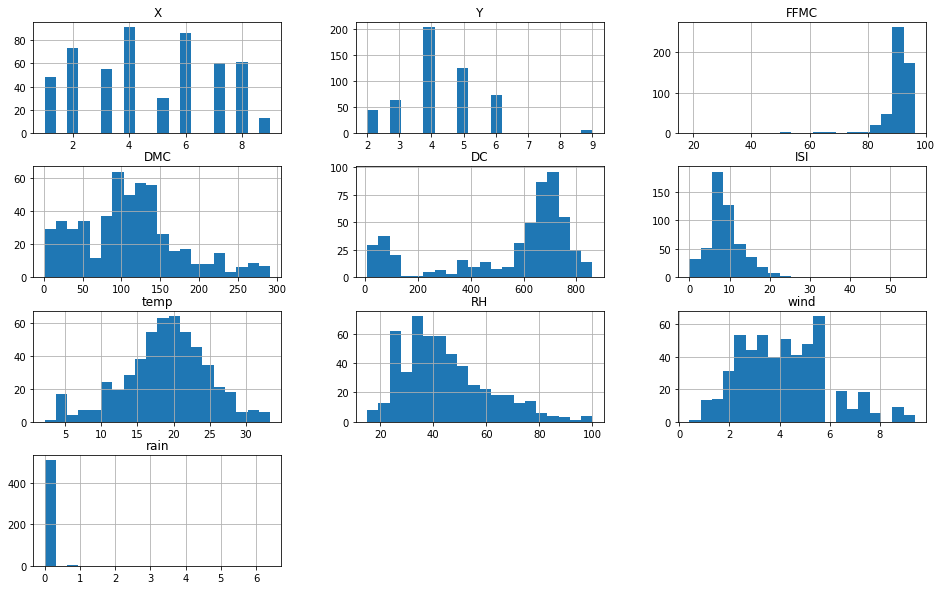

In [12]:
Xwork[variables_numericas].hist(figsize=(16,10),bins = 20)
plt.show()

También comprobamos el rango intercuantil.

X           AxesSubplot(0.125,0.71587;0.227941x0.16413)
Y        AxesSubplot(0.398529,0.71587;0.227941x0.16413)
FFMC     AxesSubplot(0.672059,0.71587;0.227941x0.16413)
DMC        AxesSubplot(0.125,0.518913;0.227941x0.16413)
DC      AxesSubplot(0.398529,0.518913;0.227941x0.16413)
ISI     AxesSubplot(0.672059,0.518913;0.227941x0.16413)
temp       AxesSubplot(0.125,0.321957;0.227941x0.16413)
RH      AxesSubplot(0.398529,0.321957;0.227941x0.16413)
wind    AxesSubplot(0.672059,0.321957;0.227941x0.16413)
rain          AxesSubplot(0.125,0.125;0.227941x0.16413)
dtype: object

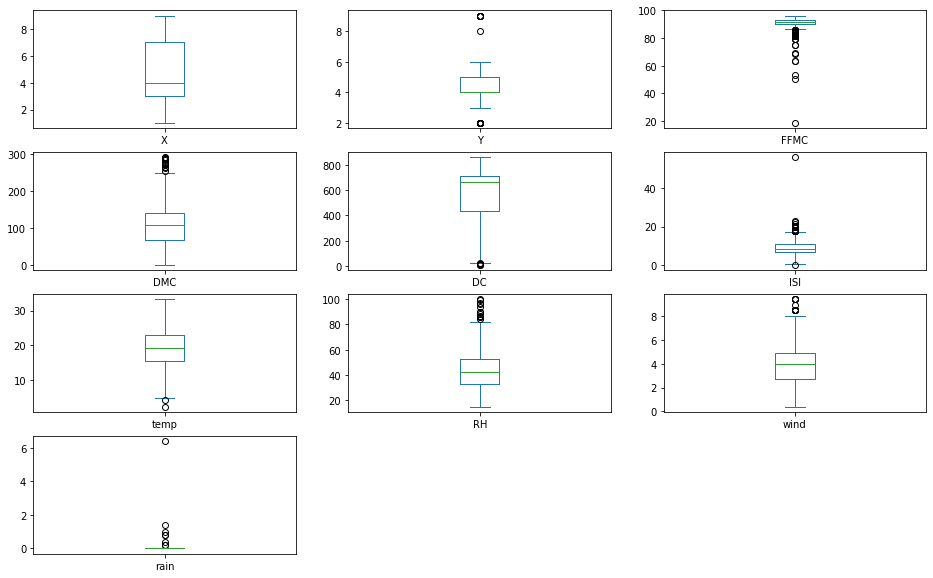

In [13]:
Xwork[variables_numericas].plot(kind = 'box', subplots = True, layout = (4,3) , sharex = False, sharey = False, figsize=(16,10))

Hemos observado outliers en las variables de : FFMC, ISI, rain , RH Y DMC. En variables como wind, temp, DC e Y hay una presencia menor de outliers. Aun asi decidimos al final tratar todos las variables numéricas.
    


## IQR percentile

Hemos decidido aplicar este método frente al basado en estadística (de de la media con la desviación) porque puede generar muchos falsos positivos.

In [14]:
# Importamos la clase TransformerMixin
from sklearn.base import TransformerMixin

# Creamos la clase de detección y tratamiento de Outliers
class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5):
        self.k=k
    
    # Método fit
    def fit(self, X, y=None):
        self.stats = X.describe()
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        variables_numericas = Xaux.columns[Xaux.dtypes != object].tolist()
        # Se calcula el IQR de cada variable
        IQRs = self.stats.loc['75%',:] - self.stats.loc['25%',:]
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc['25%',:] - (self.k*IQRs)
        limiteSup = self.stats.loc['75%',:] + (self.k*IQRs)
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)
        menores = Xaux.loc[:,variables_numericas] < limiteInf
        mayores = Xaux.loc[:,variables_numericas] > limiteSup
        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        for c in variables_numericas:
            # obtenemos los índices de los outliers: creamos una lista (tolist) con el resultado del logical_or        
            indices = np.logical_or(menores[c],mayores[c]).tolist()
            # Si hay outliers
            # <RELLENAR>
            if True in indices:
                # Obtenemos los valores del índice del DataFrame (.index) de dichos outliers y los pasamos a una lista (.flatten())
                indices = np.argwhere(indices).flatten()
                indices = Xaux.index[indices]
                # Los sustituimos por la mediana
                # <RELLENAR>
                Xaux.loc[indices,c] =self.stats.loc['50%',c]
        # Se devuelve el DataFrame modificado
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

## Distribución variables tras detección de outliers

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(Xwork,y,train_size = 0.8,stratify=y,random_state=42)

out = OutlierDetecion_treatment_IQR(3)
X_IQRwork = out.fit_transform(X_train)

X           AxesSubplot(0.125,0.71587;0.227941x0.16413)
Y        AxesSubplot(0.398529,0.71587;0.227941x0.16413)
FFMC     AxesSubplot(0.672059,0.71587;0.227941x0.16413)
DMC        AxesSubplot(0.125,0.518913;0.227941x0.16413)
DC      AxesSubplot(0.398529,0.518913;0.227941x0.16413)
ISI     AxesSubplot(0.672059,0.518913;0.227941x0.16413)
temp       AxesSubplot(0.125,0.321957;0.227941x0.16413)
RH      AxesSubplot(0.398529,0.321957;0.227941x0.16413)
wind    AxesSubplot(0.672059,0.321957;0.227941x0.16413)
rain          AxesSubplot(0.125,0.125;0.227941x0.16413)
dtype: object

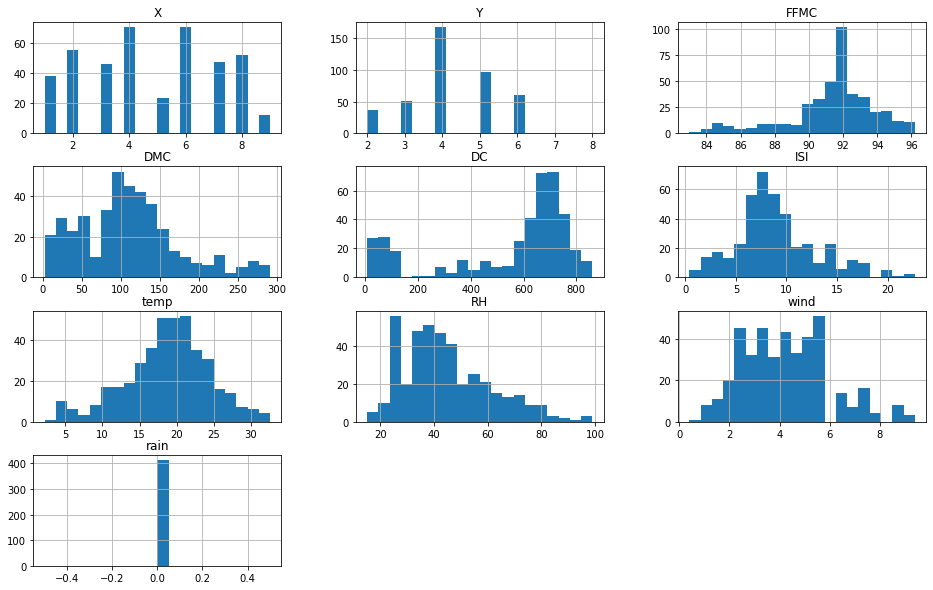

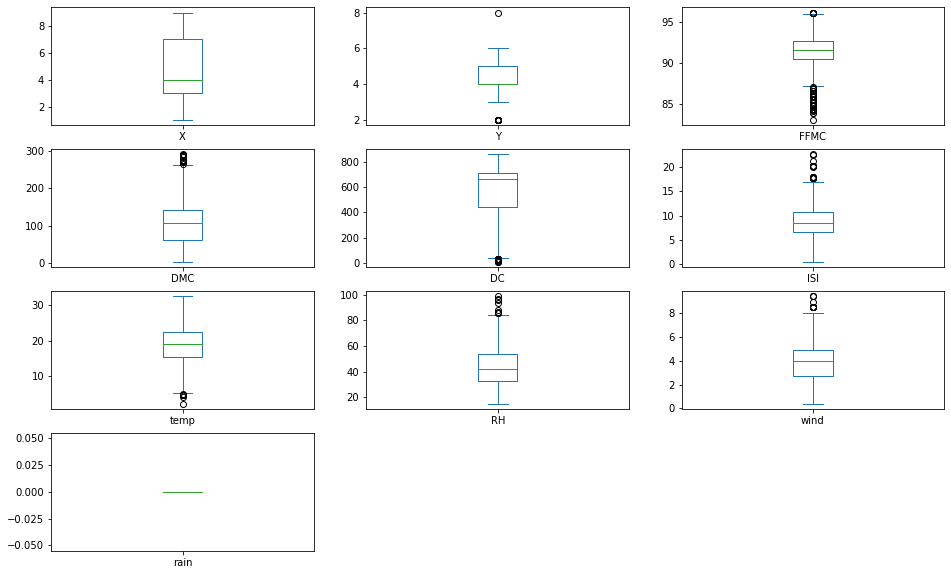

In [16]:
X_IQRwork[variables_numericas].hist(figsize=(16,10),bins = 20)

X_IQRwork[variables_numericas].plot(kind = 'box', subplots = True, layout = (4,3) , sharex = False, sharey = False, figsize=(16,10))

#### Cambios después de aplicar IQR

Podemos observar que los outliers han sido eliminados correctamente.

## Analisis de correlaciones

Analizamos la correlación de variables tras tratar los outliers.

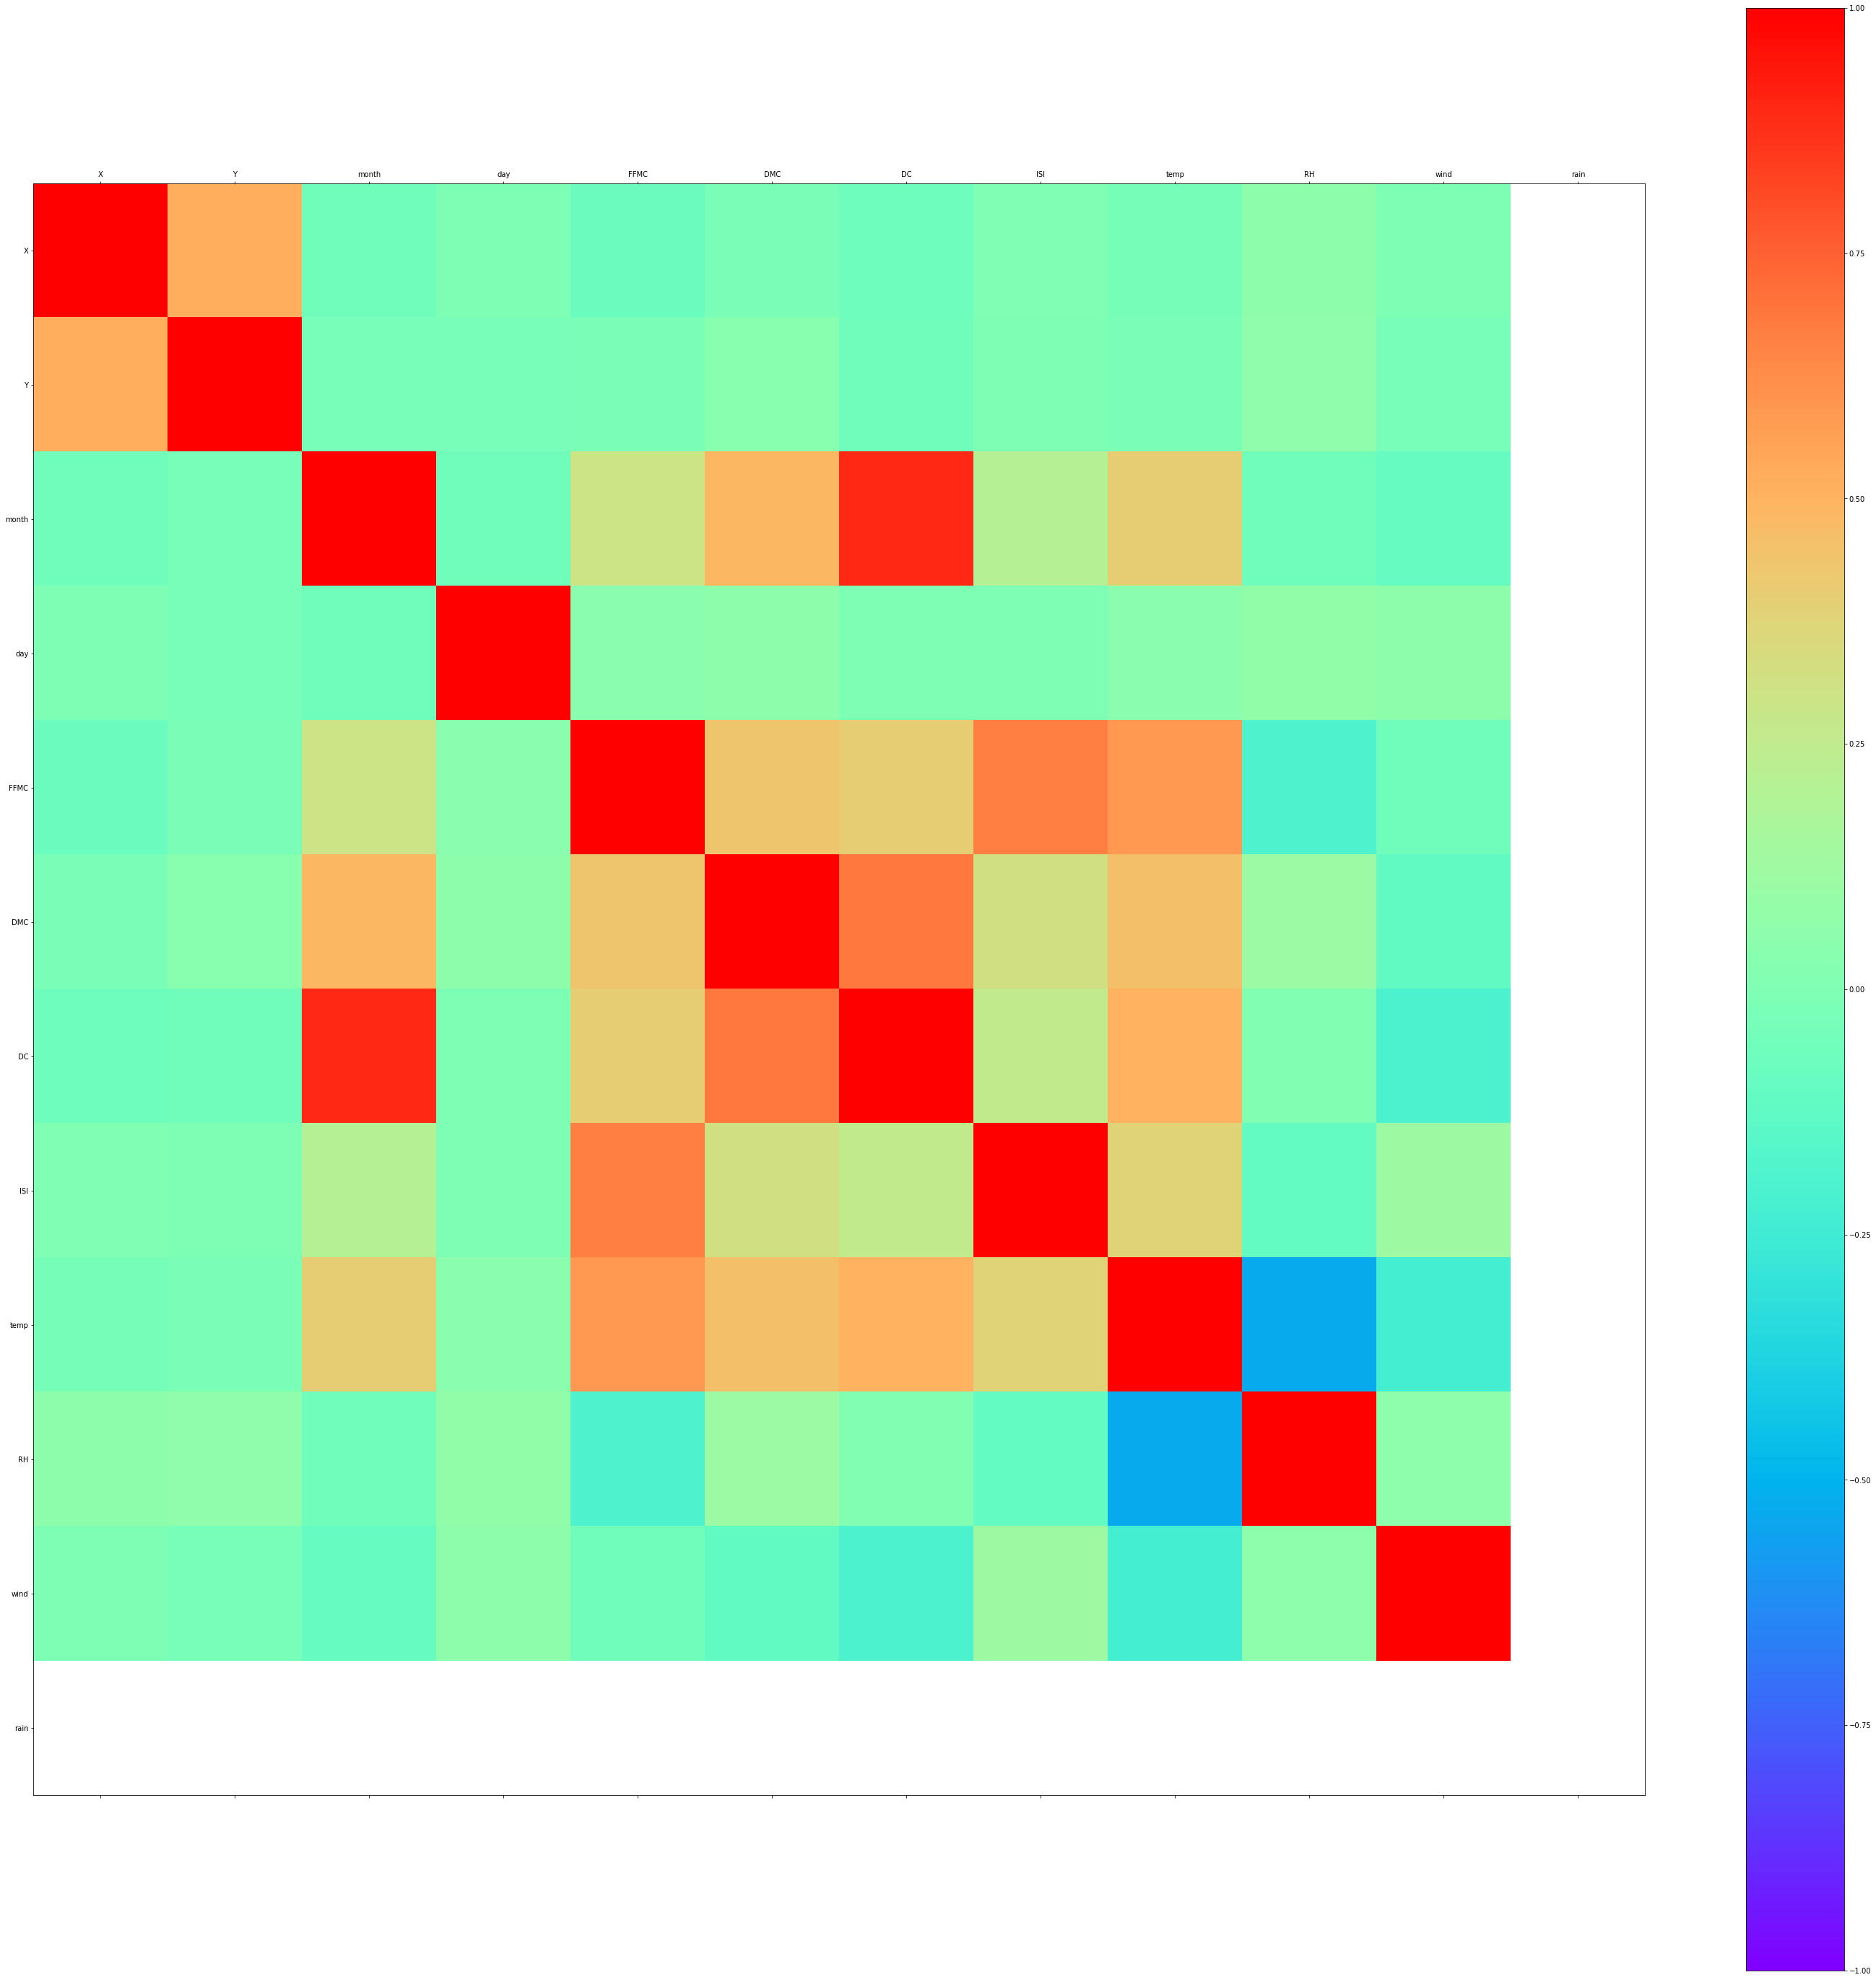

In [17]:
import matplotlib.pyplot as plt

# Calculamos la matriz de correlaciones con la función corr de pandas sobre los datos de train
correlaciones = X_IQRwork.corr()

# Mostramos la matriz de correlaciones especificando el rango de los valores [-1, 1]
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111)
cax = ax.matshow(correlaciones, vmin=-1, vmax=1, cmap=plt.cm.rainbow)
fig.colorbar(cax)
ticks = np.arange(0,len(X_IQRwork.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
# Añadimos los nombres de las variables en la figura
names = X_IQRwork.columns
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

Observamos que tras la detección de outliers en la variable rain todos los valores se han quedado a 0. Esto se debe a que la mayoría de los valores son cero. Para conservar esta información decidimos transformar esta variable a categórica. 

In [18]:
mask = Xwork['rain']>0 
Xwork.loc[mask,'rain'] = 1
X_IQRwork['rain'] = Xwork['rain']

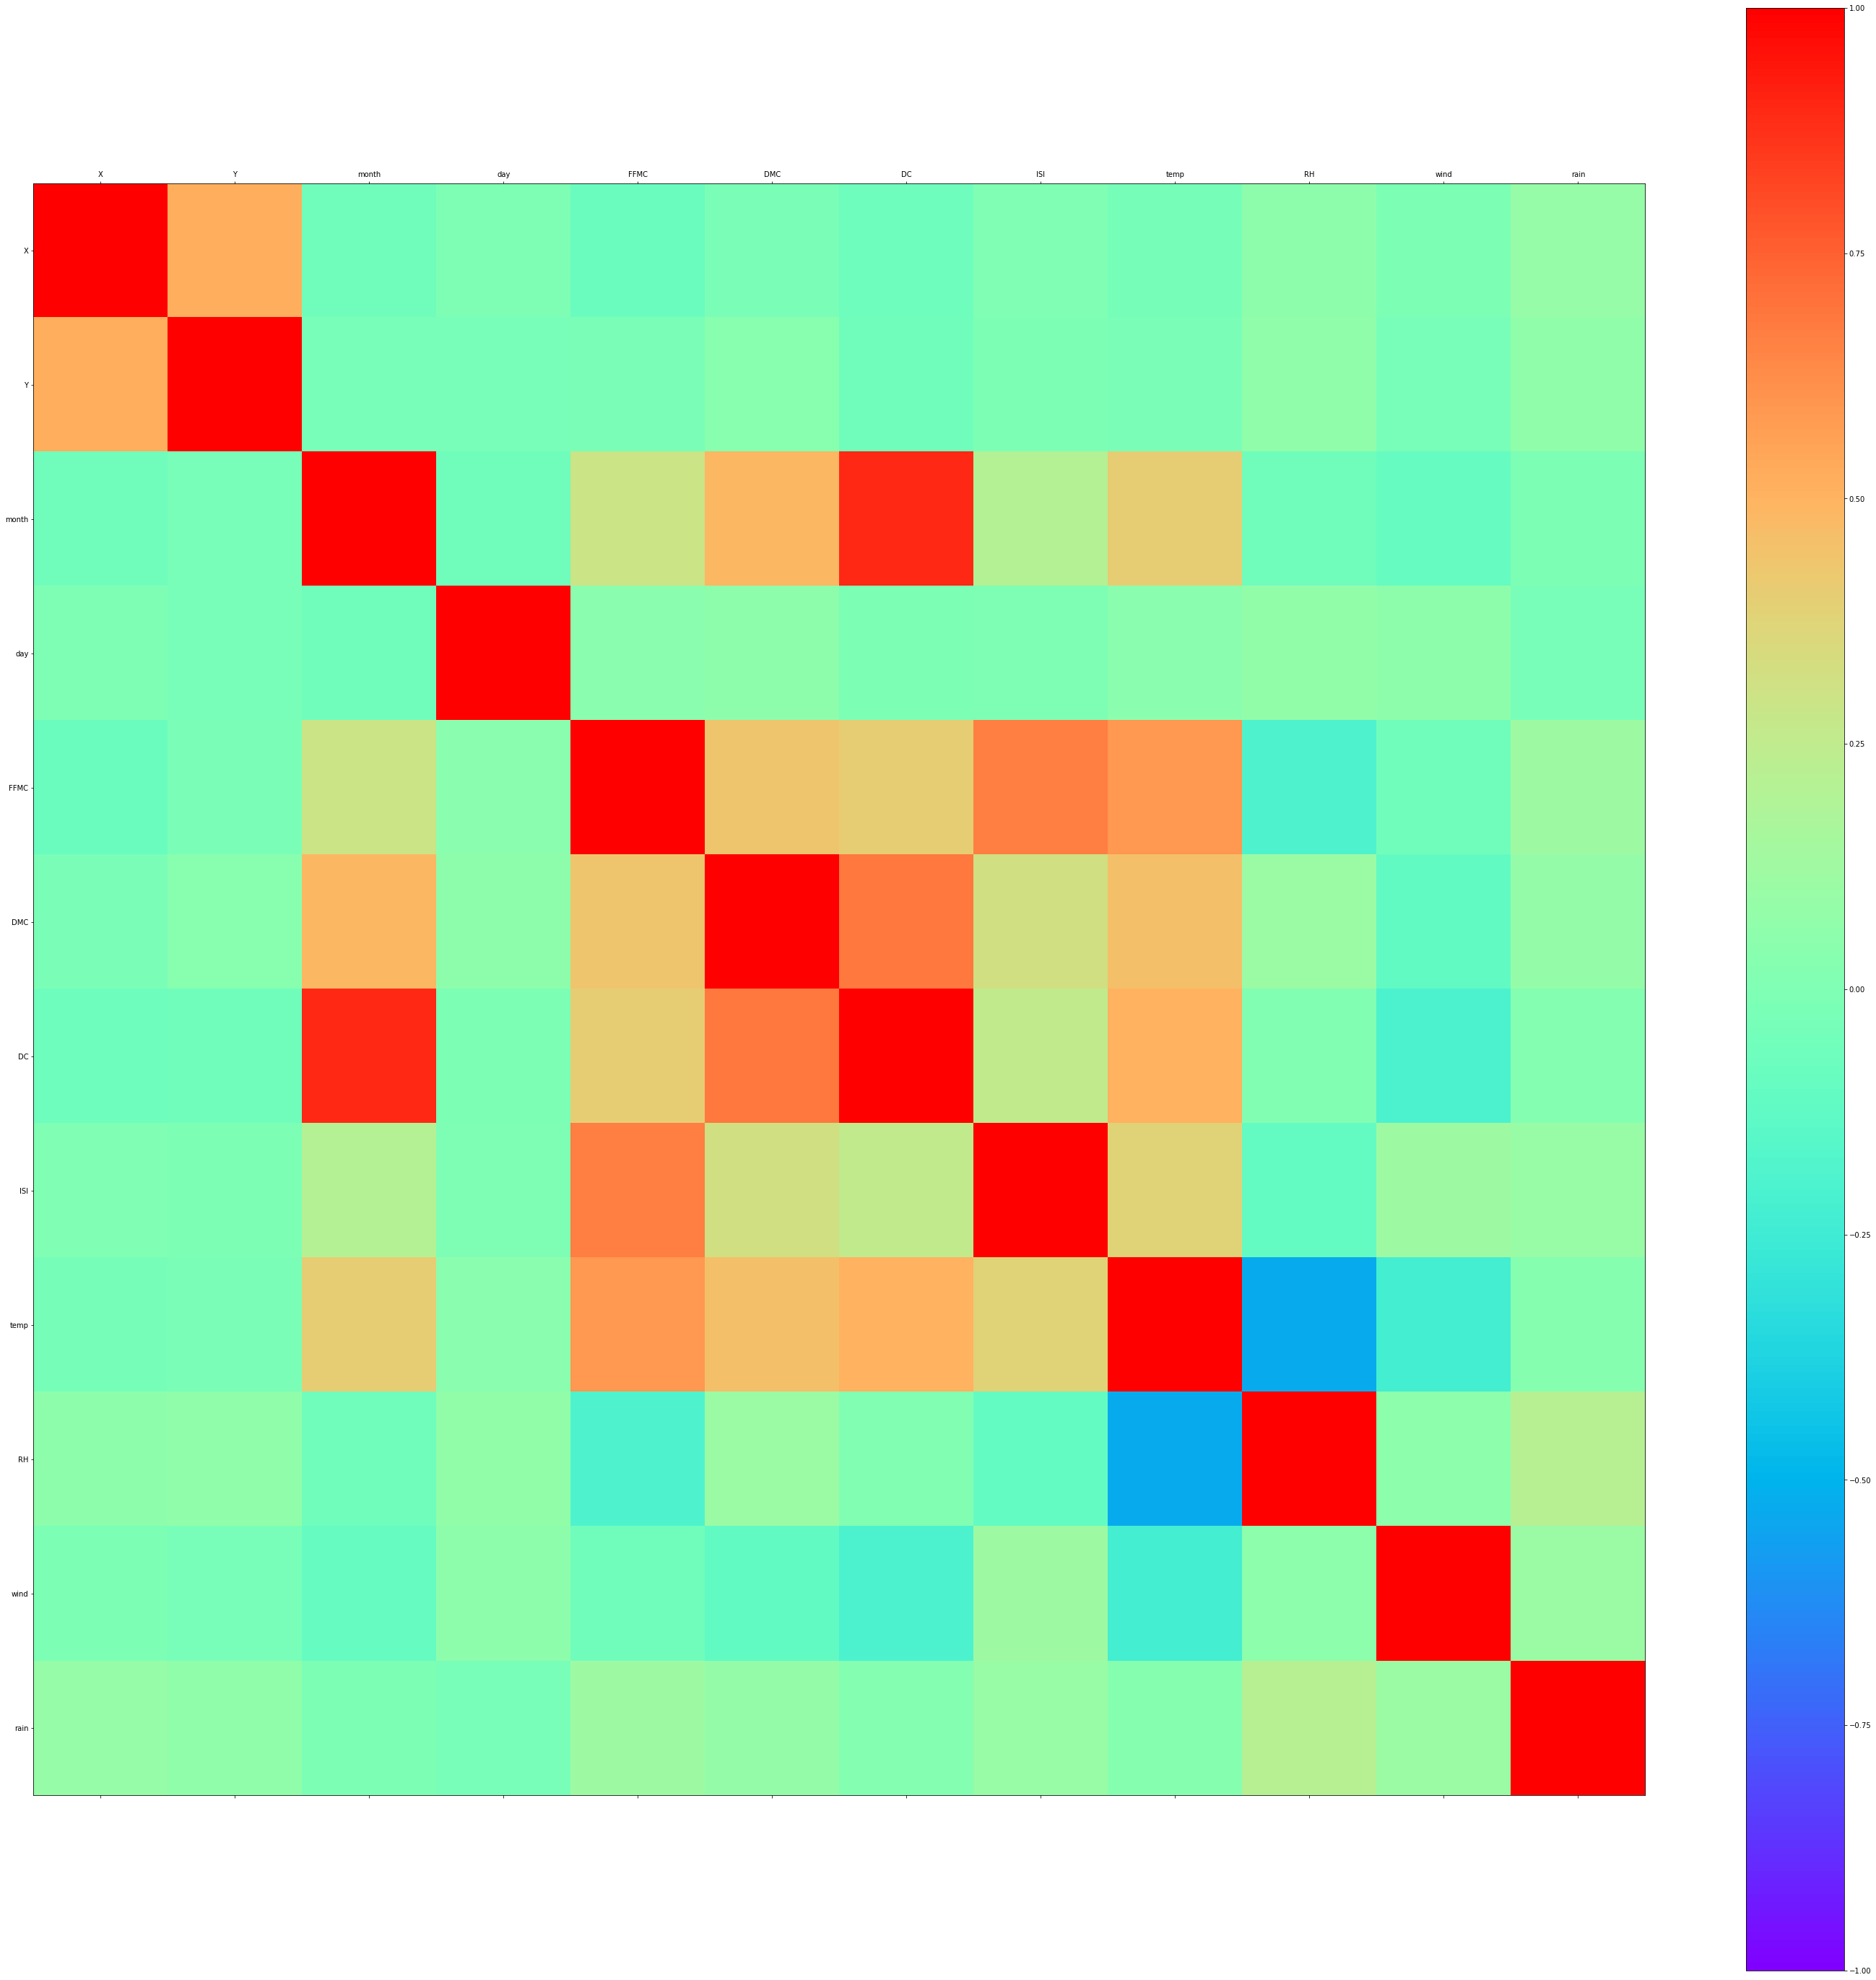

In [19]:
import matplotlib.pyplot as plt

# Calculamos la matriz de correlaciones con la función corr de pandas sobre los datos de train
correlaciones = X_IQRwork.corr()

# Mostramos la matriz de correlaciones especificando el rango de los valores [-1, 1]
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111)
cax = ax.matshow(correlaciones, vmin=-1, vmax=1, cmap=plt.cm.rainbow)
fig.colorbar(cax)
ticks = np.arange(0,len(X_IQRwork.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
# Añadimos los nombres de las variables en la figura
names = X_IQRwork.columns
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

Probamos a eliminar variables muy correlacionadas

In [20]:
# Creamos la matriz de correlación en valor absoluto: función abs (da igual se se correlacionan positiva o negativamente)
corr_matrix = abs(correlaciones)

# Seleccionamos el triángulo superior de la matriz de correlación
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))
# Umbral deseado para determinar variables correlacionadas
umbral = 0.8
# Obtenemos los índices de aquellas variables con correlación mayor al umbral deseado
indices_variables_a_eliminar = [i for i,column in enumerate(upper.columns) if any(upper[column] > umbral)]

# Creamos una copia de los datos de train para poder seguir trabajando con ellos posteriormente
datos_train = X_IQRwork.copy()
# Eliminamos las variables con alta correlación con algunda de las variables de entrada 
datos_train = datos_train.drop(datos_train.columns[indices_variables_a_eliminar], axis=1)
# Mostramos las dimensiones del problema tras reducir las variables redundantes
print(datos_train.shape)

(413, 11)


In [21]:
datos_train

,X,Y,month,day,FFMC,DMC,ISI,temp,RH,wind,rain
475,2,5,5,3,93.7,121.7,18.0,22.7,40,9.4,0.0
399,9,5,5,2,93.3,49.5,14.0,28.0,34,4.5,0.0
122,3,4,8,6,92.4,124.1,8.5,22.5,42,5.4,0.0
216,4,4,8,6,92.4,124.1,8.5,16.9,60,1.3,0.0
209,8,3,8,3,93.7,80.9,17.9,23.2,26,4.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...
463,6,5,1,1,91.6,4.4,1.9,4.6,82,6.3,0.0
164,8,5,8,6,89.7,90.0,4.8,17.8,67,2.2,0.0
238,6,5,8,5,92.5,121.1,8.6,25.1,27,4.0,0.0
22,7,4,5,6,94.3,96.3,8.4,21.0,44,4.5,0.0


Variable DC muy correlacionada con month. En meses de verano valores de DC más altos, más sequía. Más tarde comprobamos que no afecta a la predicción de test eliminar esta variable por lo que hemos decidido mantenerla. Además de que la consideramos que es una variable que aporta información importante DC ,Drought code.


### Análisis del área quemada por meses

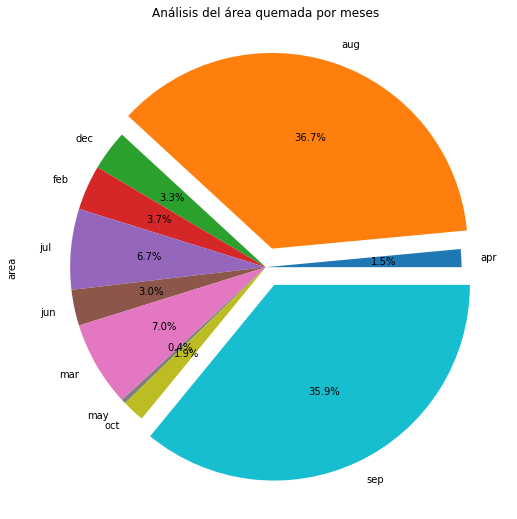

In [22]:
areaburnt=datos[datos['area']>0]
areaburnt
areaburnt.groupby('month')['area'].agg('count').plot(kind='pie',title='Análisis del área quemada por meses',figsize=(9,9),explode=[0,0.1,0,0,0,0,0,0,0,0.1],autopct='%0.1f%%')
plt.show()

Vemos que en los meses de verano hay más posibilidad de incendio que en el resto de meses. Por eso decidimos crear una nueva variables que indique si un mes es de verano o no.

### Análisis del área quemada por días

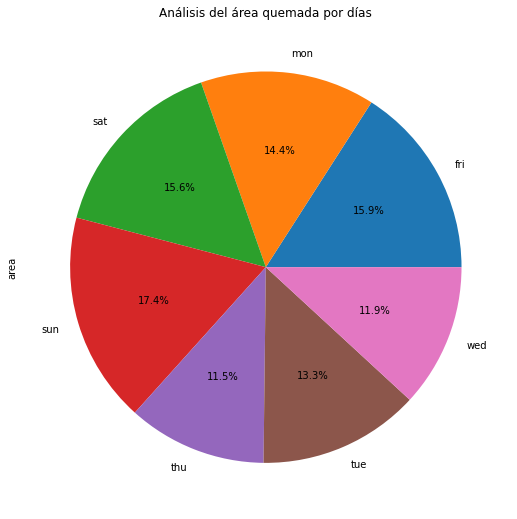

In [23]:
areaburnt=datos[datos['area']>0]
areaburnt
areaburnt.groupby('day')['area'].agg('count').plot(kind='pie',title='Análisis del área quemada por días',figsize=(9,9),autopct='%0.1f%%')
plt.show()

Observamos que en la distribución entre los días es parecida. En un principio como en los días de finde semana (fri, sat, sun) vemos que hay mas % creamos una nueva variable de finde_semana , que finalmente en el filtro ANOVA nos lo descarta. Ya que al ser la distribución parecida no nos aporta información de más.

## Pipeline KNN: primeras pruebas para ver el funcionamiento del modelo

In [24]:
from sklearn.pipeline import Pipeline
# errorPipeline = <RELLENAR>
pipeline = Pipeline([('tipoDeteccionOutlier', OutlierDetecion_treatment_IQR(k = 3)),('codificacion',ordinal) ,('estandarizacion', preprocessing.StandardScaler()),  ('modelo',KNeighborsClassifier())])
pipeline.fit(X_train,y_train)
predicciones = pipeline.predict(X_train)
accuracy_train = accuracy_score(predicciones, y_train)*100
print('Accuracy en train: ',accuracy_train)

prediccionesTest = pipeline.predict(X_test)
accuracy_est = accuracy_score(prediccionesTest, y_test)*100
print('Accuracy en test: ',accuracy_est)

Accuracy en train:  65.13317191283294
Accuracy en test:  54.807692307692314


C:\Users\lukep\anaconda3\envs\py38ml\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\lukep\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Obtenemos una idea de los resultados iniciales.

### Preparación de datos a entrenar, con los cambios descritos previamente.

In [25]:
X =ordinal.fit_transform(X)
Xaux = X.copy()
##añadimos atributos finde_semana, verano (explicado anteriormente)
Xaux['finde_semana'] = np.zeros(len(Xaux))
Xaux['verano'] = np.zeros(len(Xaux))
Xaux.loc[Xaux.day>4,'finde_semana']=1
Xaux.loc[(Xaux.month>5) & (Xaux.month< 9) ,'verano']=1
X_train, X_test, y_train, y_test = model_selection.train_test_split(Xaux,y,train_size = 0.8,stratify=y,random_state=42)

# Instanciamos la clase anterior, la entrenamos y transformamos del DataFrame
out = OutlierDetecion_treatment_IQR(3)
X_IQR = out.fit_transform(X_train)
#modificamos columna de rain (explicado anteriormente)
mask = X_train['rain']>0 
X_IQR.loc[mask,'rain'] = 1
#creo copia X_IQR con DC para despues hacer las pruebas
X_IQR_DC = X_IQR.copy()
X_IQR = X_IQR.drop(columns='DC')
normalizarmedia = preprocessing.StandardScaler()
X_train = normalizarmedia.fit_transform(X_IQR)

X_test_IQR = out.transform(X_test)
#modificamos columna de rain (explicado anteriormente)
mask = X_test['rain']>0 
X_test_IQR.loc[mask,'rain'] = 1
X_test_DC = X_test_IQR.copy()
X_test = X_test_IQR.drop(columns='DC')
X_test = normalizarmedia.transform(X_test) 
columnas = list(Xaux.columns)
columnas.remove('DC')
columnas = np.array(columnas)

C:\Users\lukep\anaconda3\envs\py38ml\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [26]:
X_train_DC = normalizarmedia.fit_transform(X_IQR_DC)
X_test_DC = normalizarmedia.transform(X_test_DC) 
columnas_DC = Xaux.columns

Probamos a quitar el atributo DC (que nos salía correlacionado con los meses), más tarde compararemos resultados sin él para ver como varían.

## Selección de variables

Hemos descartado usar chi2 porque no admitía valores negativos.

### FILTRO ANOVA: Sin DC

In [27]:
listaAccTrain = [] # lista para almancenar el rendimiento de las diferentes posibilidades en train
listaAccTest = [] # lista para almancenar el rendimiento de las diferentes posibilidades en test
# <RELLENAR>
listaClf = []
y_train = y_train.ravel()
y_test = y_test.ravel()
for numVar in [6,7,8,9,10,11,12]:
    # Se llama al constructor que realiza la selección de las k mejores variables con los parámetros apropiados
    tecnicaSeleccion = feature_selection.SelectKBest( score_func = feature_selection.f_classif,k = numVar)
    # Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
    tecnicaSeleccion.fit(X_train,y_train)
    # Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
    X_train_seleccion = tecnicaSeleccion.transform(X_train)
    # Llamada a la función que transforma los datos de test: realiza la selección de variables
    X_test_seleccion = tecnicaSeleccion.transform(X_test)
    # Realizamos el proceso para KNN por lo que hay que llamar al constructor de dicho clasificador
#     print(tecnicaSeleccion.get_support())
#     print( Xaux.columns.values)
    listaVariables = columnas[tecnicaSeleccion.get_support()]
    print(listaVariables)
    knn = KNeighborsClassifier()
    # Llamada a la función que realiza el aprendizaje del clasificador
    knn.fit(X_train_seleccion,y_train)
    listaClf.append(knn)
    # Llamada a la función que realiza la predicción de los datos de entrenamiento
    prediccionTrain = knn.predict(X_train_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
    accTrain = accuracy_score(y_train,prediccionTrain)*100
    # Se añade el resultado a la lista de resultados de train
    # <RELLENAR>
    listaAccTrain.append(accTrain)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en entrenamiento'.format(numVar, accTrain))
    # Llamada a la función que realiza la predicción de los datos de test
    prediccionTest =  knn.predict(X_test_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de test
    accTest = accuracy_score(y_test,prediccionTest)*100
    # Se añade el resultado a la lista de resultados de test
    # <RELLENAR>
    listaAccTest.append(accTest)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en test'.format(numVar, accTest))

['Y' 'month' 'DMC' 'ISI' 'temp' 'verano']
Seleccionando las 6 mejores variables se obtiene un accuracy del 71.67070217917676% en entrenamiento
Seleccionando las 6 mejores variables se obtiene un accuracy del 60.57692307692307% en test
['X' 'Y' 'month' 'DMC' 'ISI' 'temp' 'verano']
Seleccionando las 7 mejores variables se obtiene un accuracy del 70.70217917675545% en entrenamiento
Seleccionando las 7 mejores variables se obtiene un accuracy del 58.65384615384615% en test
['X' 'Y' 'month' 'FFMC' 'DMC' 'ISI' 'temp' 'verano']
Seleccionando las 8 mejores variables se obtiene un accuracy del 69.73365617433413% en entrenamiento
Seleccionando las 8 mejores variables se obtiene un accuracy del 63.46153846153846% en test
['X' 'Y' 'month' 'FFMC' 'DMC' 'ISI' 'temp' 'RH' 'verano']
Seleccionando las 9 mejores variables se obtiene un accuracy del 70.46004842615012% en entrenamiento
Seleccionando las 9 mejores variables se obtiene un accuracy del 57.692307692307686% en test
['X' 'Y' 'month' 'FFMC' 'DMC

Seleccionando las 8 mejores variables se obtiene un accuracy del 63.46% en test, el mejor resultado hasta ahora. 
Las variables seleccionadas son:
- ['X' 'Y' 'month' 'FFMC' 'DMC' 'ISI' 'temp' 'verano']

### FILTRO ANOVA: con DC 

In [28]:
listaAccTrain = [] # lista para almancenar el rendimiento de las diferentes posibilidades en train
listaAccTest = [] # lista para almancenar el rendimiento de las diferentes posibilidades en test
# <RELLENAR>
y_train = y_train.ravel()
y_test = y_test.ravel()
for numVar in [6,7,8,9,10,11,12,13]:
# <RELLENAR>
    # Se llama al constructor que realiza la selección de las k mejores variables con los parámetros apropiados
    tecnicaSeleccion = feature_selection.SelectKBest( score_func = feature_selection.f_classif,k = numVar)
    # Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
    tecnicaSeleccion.fit(X_train_DC,y_train)
    # Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
    X_train_seleccion = tecnicaSeleccion.transform(X_train_DC)
    # Llamada a la función que transforma los datos de test: realiza la selección de variables
    X_test_seleccion = tecnicaSeleccion.transform(X_test_DC)
    # Realizamos el proceso para KNN por lo que hay que llamar al constructor de dicho clasificador
#     print(tecnicaSeleccion.get_support())
#     print( Xaux.columns.values)
    listaVariables = columnas_DC[tecnicaSeleccion.get_support()]
    print(listaVariables)
    knn = KNeighborsClassifier()
    # Llamada a la función que realiza el aprendizaje del clasificador
    knn.fit(X_train_seleccion,y_train)
    # Llamada a la función que realiza la predicción de los datos de entrenamiento
    prediccionTrain = knn.predict(X_train_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
    accTrain = accuracy_score(y_train,prediccionTrain)*100
    # Se añade el resultado a la lista de resultados de train
    # <RELLENAR>
    listaAccTrain.append(accTrain)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en entrenamiento'.format(numVar, accTrain))
    # Llamada a la función que realiza la predicción de los datos de test
    prediccionTest =  knn.predict(X_test_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de test
    accTest = accuracy_score(y_test,prediccionTest)*100
    # Se añade el resultado a la lista de resultados de test
    # <RELLENAR>
    listaAccTest.append(accTest)
    print('Seleccionando las {} mejores variables se obtiene un accuracy del {}% en test'.format(numVar, accTest))

Index(['month', 'DMC', 'DC', 'ISI', 'temp', 'verano'], dtype='object')
Seleccionando las 6 mejores variables se obtiene un accuracy del 69.73365617433413% en entrenamiento
Seleccionando las 6 mejores variables se obtiene un accuracy del 59.61538461538461% en test
Index(['Y', 'month', 'DMC', 'DC', 'ISI', 'temp', 'verano'], dtype='object')
Seleccionando las 7 mejores variables se obtiene un accuracy del 70.70217917675545% en entrenamiento
Seleccionando las 7 mejores variables se obtiene un accuracy del 58.65384615384615% en test
Index(['X', 'Y', 'month', 'DMC', 'DC', 'ISI', 'temp', 'verano'], dtype='object')
Seleccionando las 8 mejores variables se obtiene un accuracy del 69.97578692493947% en entrenamiento
Seleccionando las 8 mejores variables se obtiene un accuracy del 57.692307692307686% en test
Index(['X', 'Y', 'month', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'verano'], dtype='object')
Seleccionando las 9 mejores variables se obtiene un accuracy del 69.24939467312349% en entrenamiento
Se

Seleccionando las 10 mejores variables con ANOVA usando DC se obtiene un accuracy del 63.46% en test, el mejor resultado en este caso. Las variables seleccionadas son:
- ['X', 'Y', 'month', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'verano']

Implementamos distintos métodos basados en wrappers para ver si mejoraba el rendimiento.

## MÉTODOS BASADOS EN WRAPPERS

### RFE: sin DC

In [29]:
from sklearn import linear_model

# Listas para almacenar los resultados de accuracy en train y test
listaAccTrain = []
listaAccTest = []
for variablesMantener in [6,7,8,9,10,11,12]:
# <RELLENAR>
    # Se llama al constructor que realiza la selección de variables en base a la eliminación secuencial de variables
        # Utiliza los parámetros adecuados
    tecnicaSeleccion =  feature_selection.RFE(linear_model.LogisticRegression(solver = 'liblinear'),n_features_to_select=variablesMantener, step =1)
    # Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
    tecnicaSeleccion.fit(X_train, y_train)
    # variables seleccionadas.
    listaVariables = columnas[tecnicaSeleccion.get_support()]
    print(listaVariables)
    # Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
    X_train_seleccion = tecnicaSeleccion.transform(X_train)
    # Llamada a la función que transforma los datos de test: realiza la selección de variables
    X_test_seleccion =  tecnicaSeleccion.transform(X_test)
    # Realizamos el proceso para la regresión logística por lo que hay que llamar al constructor de dicho clasificador con la configuración apropiada
    RL =  linear_model.LogisticRegression(solver = 'liblinear')
    # Llamada a la función que realiza el aprendizaje del clasificador
    RL.fit(X_train_seleccion,y_train)
    # Llamada a la función que realiza la predicción de los datos de entrenamiento
    prediccionTrain = RL.predict(X_train_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
    accTrain =accuracy_score(y_train,prediccionTrain)*100
    # Se añade el resultado a la lista de resultados de train
    # <RELLENAR>
    listaAccTrain.append(accTrain)
    print('Manteniendo {} variables se obtiene un accuracy del {}% en entrenamiento'.format(variablesMantener, accTrain))
    # Llamada a la función que realiza la predicción de los datos de test
    prediccionTest = RL.predict(X_test_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de test
    accTest =  accuracy_score(y_test,prediccionTest)*100
    # Se añade el resultado a la lista de resultados de test
    # <RELLENAR>
    listaAccTest.append(accTest)
    print('Manteniendo {} variables se obtiene un accuracy del {}% en test'.format(variablesMantener, accTest))

['X' 'Y' 'month' 'temp' 'wind' 'rain']
Manteniendo 6 variables se obtiene un accuracy del 57.869249394673126% en entrenamiento
Manteniendo 6 variables se obtiene un accuracy del 55.769230769230774% en test
['X' 'Y' 'month' 'ISI' 'temp' 'wind' 'rain']
Manteniendo 7 variables se obtiene un accuracy del 58.595641646489106% en entrenamiento
Manteniendo 7 variables se obtiene un accuracy del 54.807692307692314% en test
['X' 'Y' 'month' 'FFMC' 'ISI' 'temp' 'wind' 'rain']
Manteniendo 8 variables se obtiene un accuracy del 58.83777239709443% en entrenamiento
Manteniendo 8 variables se obtiene un accuracy del 53.84615384615385% en test
['X' 'Y' 'month' 'FFMC' 'ISI' 'temp' 'wind' 'rain' 'verano']
Manteniendo 9 variables se obtiene un accuracy del 60.048426150121074% en entrenamiento
Manteniendo 9 variables se obtiene un accuracy del 55.769230769230774% en test
['X' 'Y' 'month' 'FFMC' 'DMC' 'ISI' 'temp' 'wind' 'rain' 'verano']
Manteniendo 10 variables se obtiene un accuracy del 59.80629539951574%

Seleccionando las 12 mejores variables con RFE sin coger DC se obtiene un accuracy del 58.65% en test, el mejor resultado en este caso. Las variables seleccionadas son:
- ['X' 'Y' 'month' 'day' 'FFMC' 'DMC' 'ISI' 'temp' 'RH' 'wind' 'rain'
 'verano']

### RFE: con DC

In [30]:
from sklearn import linear_model

# Listas para almacenar los resultados de accuracy en train y test
listaAccTrain = []
listaAccTest = []
for variablesMantener in [6,7,8,9,10,11,12,13]:
# <RELLENAR>
    # Se llama al constructor que realiza la selección de variables en base a la eliminación secuencial de variables
        # Utiliza los parámetros adecuados
    tecnicaSeleccion =  feature_selection.RFE(linear_model.LogisticRegression(solver = 'liblinear'),n_features_to_select=variablesMantener, step =1)
    # Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
    tecnicaSeleccion.fit(X_train_DC, y_train)
    # variables seleccionadas.
    listaVariables = columnas_DC[tecnicaSeleccion.get_support()]
    print(listaVariables)
    # Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
    X_train_seleccion = tecnicaSeleccion.transform(X_train_DC)
    # Llamada a la función que transforma los datos de test: realiza la selección de variables
    X_test_seleccion =  tecnicaSeleccion.transform(X_test_DC)
    # Realizamos el proceso para la regresión logística por lo que hay que llamar al constructor de dicho clasificador con la configuración apropiada
    RL =  linear_model.LogisticRegression(solver = 'liblinear')
    # Llamada a la función que realiza el aprendizaje del clasificador
    RL.fit(X_train_seleccion,y_train)
    # Llamada a la función que realiza la predicción de los datos de entrenamiento
    prediccionTrain = RL.predict(X_train_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
    accTrain =accuracy_score(y_train,prediccionTrain)*100
    # Se añade el resultado a la lista de resultados de train
    # <RELLENAR>
    listaAccTrain.append(accTrain)
    print('Manteniendo {} variables se obtiene un accuracy del {}% en entrenamiento'.format(variablesMantener, accTrain))
    # Llamada a la función que realiza la predicción de los datos de test
    prediccionTest = RL.predict(X_test_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de test
    accTest =  accuracy_score(y_test,prediccionTest)*100
    # Se añade el resultado a la lista de resultados de test
    # <RELLENAR>
    listaAccTest.append(accTest)
    print('Manteniendo {} variables se obtiene un accuracy del {}% en test'.format(variablesMantener, accTest))

Index(['X', 'month', 'DC', 'temp', 'wind', 'verano'], dtype='object')
Manteniendo 6 variables se obtiene un accuracy del 58.111380145278446% en entrenamiento
Manteniendo 6 variables se obtiene un accuracy del 52.88461538461539% en test
Index(['X', 'month', 'DC', 'temp', 'wind', 'rain', 'verano'], dtype='object')
Manteniendo 7 variables se obtiene un accuracy del 57.869249394673126% en entrenamiento
Manteniendo 7 variables se obtiene un accuracy del 52.88461538461539% en test
Index(['X', 'Y', 'month', 'DC', 'temp', 'wind', 'rain', 'verano'], dtype='object')
Manteniendo 8 variables se obtiene un accuracy del 58.83777239709443% en entrenamiento
Manteniendo 8 variables se obtiene un accuracy del 55.769230769230774% en test
Index(['X', 'Y', 'month', 'DMC', 'DC', 'temp', 'wind', 'rain', 'verano'], dtype='object')
Manteniendo 9 variables se obtiene un accuracy del 57.6271186440678% en entrenamiento
Manteniendo 9 variables se obtiene un accuracy del 56.730769230769226% en test
Index(['X', 'Y',

Seleccionando las 11 mejores variables con RFE cogiendo DC se obtiene un accuracy del 57.69% en test, el mejor resultado en este caso. Las variables seleccionadas son:
- ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'wind','rain', 'verano']

RFE EMPEORA RESULTADOS

Realizadas diferentes pruebas podemos observar que no hay grandes cambios al usar o no el atributo DC, por lo que hemos decicidido a partir de ahora trabajar con el puesto que consideramos que es un atributo relevante en el problema, ya que mide el nivel humedad que tiene el suelo.

In [31]:
X_train = X_train_DC.copy()
X_test = X_test_DC.copy()
columnas = columnas_DC

Continuamos probando diversos métodos. En este caso basados en la dirección de la búsqueda.

### SEQUENTIAL FORWARD SELECTION

In [32]:
# Listas para almacenar los resultados de accuracy en train y test
listaAccTrain = []
listaAccTest = []
for variablesMantener in [6,7,8,9,10,11,12,13]:
# <RELLENAR>
    # Se llama al constructor que realiza la selección de variables en base a la introducción secuencial de variables
        # Utiliza los parámetros adecuados
    tecnicaSeleccion =  feature_selection.SequentialFeatureSelector(linear_model.LogisticRegression(solver = 'liblinear'),n_features_to_select=variablesMantener,direction='forward',n_jobs=-1)
    # Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
    tecnicaSeleccion.fit(X_train,y_train)
    # Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
    X_train_seleccion = tecnicaSeleccion.transform(X_train)
    # Llamada a la función que transforma los datos de test: realiza la selección de variables
    X_test_seleccion =  tecnicaSeleccion.transform(X_test)
    # variables seleccionadas
    listaVariables = columnas[tecnicaSeleccion.get_support()]
    print(listaVariables)
    # Realizamos el proceso para la regresión logística por lo que hay que llamar al constructor de dicho clasificador con la configuración apropiada
    RL = linear_model.LogisticRegression(solver = 'liblinear')
    # Llamada a la función que realiza el aprendizaje del clasificador
    RL.fit(X_train_seleccion,y_train)
    # Llamada a la función que realiza la predicción de los datos de entrenamiento
    prediccionTrain =  RL.predict(X_train_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
    accTrain = accuracy_score(y_train,prediccionTrain)*100
    # Se añade el resultado a la lista de resultados de train
    # <RELLENAR>
    listaAccTrain.append(accTrain)
    print('Manteniendo {} variables se obtiene un accuracy del {}% en entrenamiento'.format(variablesMantener, accTrain))
    # Llamada a la función que realiza la predicción de los datos de test
    prediccionTest =  RL.predict(X_test_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de test
    accTest = accuracy_score(y_test,prediccionTest)*100
    # Se añade el resultado a la lista de resultados de test
    # <RELLENAR>
    listaAccTest.append(accTest)
    print('Manteniendo {} variables se obtiene un accuracy del {}% en test'.format(variablesMantener, accTest))

Index(['Y', 'month', 'FFMC', 'DC', 'temp', 'rain'], dtype='object')
Manteniendo 6 variables se obtiene un accuracy del 58.35351089588377% en entrenamiento
Manteniendo 6 variables se obtiene un accuracy del 53.84615384615385% en test
Index(['Y', 'month', 'FFMC', 'DC', 'temp', 'rain', 'verano'], dtype='object')
Manteniendo 7 variables se obtiene un accuracy del 57.6271186440678% en entrenamiento
Manteniendo 7 variables se obtiene un accuracy del 57.692307692307686% en test
Index(['Y', 'month', 'FFMC', 'DC', 'temp', 'rain', 'finde_semana', 'verano'], dtype='object')
Manteniendo 8 variables se obtiene un accuracy del 57.6271186440678% en entrenamiento
Manteniendo 8 variables se obtiene un accuracy del 57.692307692307686% en test
Index(['Y', 'month', 'FFMC', 'DC', 'ISI', 'temp', 'rain', 'finde_semana',
       'verano'],
      dtype='object')
Manteniendo 9 variables se obtiene un accuracy del 58.595641646489106% en entrenamiento
Manteniendo 9 variables se obtiene un accuracy del 55.769230769

Seleccionando las 7 mejores variables con SFS se obtiene un accuracy del 57.69% en test, el mejor resultado en este caso. Las variables seleccionadas son:
-['Y', 'month', 'FFMC', 'DC', 'temp', 'rain', 'verano']

### SEQUENTIAL BACKWARD SELECTION

In [33]:
# Listas para almacenar los resultados de accuracy en train y test
listaAccTrain = []
listaAccTest = []
for variablesMantener in [6,7,8,9,10,11,12,13]:
# <RELLENAR>
    # Se llama al constructor que realiza la selección de variables en base a la introducción secuencial de variables
        # Utiliza los parámetros adecuados
    tecnicaSeleccion =  feature_selection.SequentialFeatureSelector(linear_model.LogisticRegression(solver = 'liblinear'),n_features_to_select=variablesMantener,direction='backward',n_jobs=-1)
    # Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
    tecnicaSeleccion.fit(X_train,y_train)
    # Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
    X_train_seleccion = tecnicaSeleccion.transform(X_train)
    # Llamada a la función que transforma los datos de test: realiza la selección de variables
    X_test_seleccion =  tecnicaSeleccion.transform(X_test)
        # variables seleccionadas
    listaVariables = columnas[tecnicaSeleccion.get_support()]
    print(listaVariables)
    # Realizamos el proceso para la regresión logística por lo que hay que llamar al constructor de dicho clasificador con la configuración apropiada
    RL = linear_model.LogisticRegression(solver = 'liblinear')
    # Llamada a la función que realiza el aprendizaje del clasificador
    RL.fit(X_train_seleccion,y_train)
    # Llamada a la función que realiza la predicción de los datos de entrenamiento
    prediccionTrain =  RL.predict(X_train_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
    accTrain = accuracy_score(y_train,prediccionTrain)*100
    # Se añade el resultado a la lista de resultados de train
    # <RELLENAR>
    listaAccTrain.append(accTrain)
    print('Manteniendo {} variables se obtiene un accuracy del {}% en entrenamiento'.format(variablesMantener, accTrain))
    # Llamada a la función que realiza la predicción de los datos de test
    prediccionTest =  RL.predict(X_test_seleccion)
    # Llamada a la función que calcula el porcentaje de acierto para los datos de test
    accTest = accuracy_score(y_test,prediccionTest)*100
    # Se añade el resultado a la lista de resultados de test
    # <RELLENAR>
    listaAccTest.append(accTest)
    print('Manteniendo {} variables se obtiene un accuracy del {}% en test'.format(variablesMantener, accTest))

Index(['month', 'DC', 'ISI', 'temp', 'rain', 'verano'], dtype='object')
Manteniendo 6 variables se obtiene un accuracy del 58.595641646489106% en entrenamiento
Manteniendo 6 variables se obtiene un accuracy del 50.96153846153846% en test
Index(['month', 'DMC', 'DC', 'ISI', 'temp', 'rain', 'verano'], dtype='object')
Manteniendo 7 variables se obtiene un accuracy del 58.111380145278446% en entrenamiento
Manteniendo 7 variables se obtiene un accuracy del 52.88461538461539% en test
Index(['Y', 'month', 'DMC', 'DC', 'ISI', 'temp', 'rain', 'verano'], dtype='object')
Manteniendo 8 variables se obtiene un accuracy del 59.07990314769975% en entrenamiento
Manteniendo 8 variables se obtiene un accuracy del 54.807692307692314% en test
Index(['Y', 'month', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'rain', 'verano'], dtype='object')
Manteniendo 9 variables se obtiene un accuracy del 59.07990314769975% en entrenamiento
Manteniendo 9 variables se obtiene un accuracy del 55.769230769230774% en test
Index(['Y',

Seleccionando las 10 mejores variables con SBS se obtiene un accuracy del 57.69% en test, el mejor resultado en este caso. Las variables seleccionadas son:
-['Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'rain',
       'verano']

### RFECV

In [34]:
# Se llama al constructor que realiza la selección de variables en base a la eliminación secuencial de variables utilizando RFECV
# Utiliza los parámetros adecuados
#meterlo al principio para evitar warnings
tecnicaSeleccion =  feature_selection.RFECV(linear_model.LogisticRegression(solver = 'liblinear'),n_jobs=-1,cv=5)
# Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
tecnicaSeleccion.fit(X_train,y_train)
# Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
X_train_seleccion = tecnicaSeleccion.transform(X_train)
# Llamada a la función que transforma los datos de test: realiza la selección de variables
X_test_seleccion = tecnicaSeleccion.transform(X_test)
        # variables seleccionadas
listaVariables = columnas[tecnicaSeleccion.get_support()]
print(listaVariables)
# Realizamos el proceso para la regresión logística por lo que hay que llamar al constructor de dicho clasificador con la configuración apropiada
RL = linear_model.LogisticRegression(solver = 'liblinear')
# Llamada a la función que realiza el aprendizaje del clasificador
RL.fit(X_train_seleccion,y_train)
# Llamada a la función que realiza la predicción de los datos de entrenamiento
prediccionTrain =  RL.predict(X_train_seleccion)
# Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
accTrain =  accuracy_score(y_train,prediccionTrain)*100
# Obtenemos el número de variables seleccionadas 
numeroVariablesSeleccionadas = tecnicaSeleccion.n_features_

print('Manteniendo {} variables se obtiene un accuracy del {}% en entrenamiento'.format(numeroVariablesSeleccionadas, accTrain))
# Llamada a la función que realiza la predicción de los datos de test
prediccionTest =  RL.predict(X_test_seleccion)
# Llamada a la función que calcula el porcentaje de acierto para los datos de test
accTest = accuracy_score(y_test,prediccionTest)*100
print('Manteniendo {} variables se obtiene un accuracy del {}% en test'.format(numeroVariablesSeleccionadas, accTest))

Index(['month'], dtype='object')
Manteniendo 1 variables se obtiene un accuracy del 56.90072639225182% en entrenamiento
Manteniendo 1 variables se obtiene un accuracy del 52.88461538461539% en test


El método RFECV selecciona una variable month con un accuracy de 52.88% en test.

Viendo los resultados de la selección de variables vemos que el mejor resultado lo tiene el filtro ANOVA con 10 variables 64% accuracy en test:
['X', 'Y', 'month', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'verano']


Para ello nos quedamos con el clasificador entrenado para evaluar sus métricas de rendimiento.

In [35]:
mask = [True, True, True,False, True,True,True,True,True, True, False, False,False, True]
X_train = X_train[:,mask]
X_test = X_test[:,mask]

Implementamos un gridsearch paara obtener los mejores hiperparámetros para un clasificador dado y además implementa internamente un proceso de validación cruzada.

## PREDICCIONES

### PREDICCION ANOVA+KNN CON GRIDSEARCH

In [36]:
from sklearn import model_selection

# Se crea la Pipeline con las fases deseadas
pipe = Pipeline([('KNN', KNeighborsClassifier())])
# Se crea el grid de híper-parámetros
parameters = {'KNN__n_neighbors':[1,3,5,7,9],'KNN__weights':['uniform','distance'],
              'KNN__p':[1, 2 ,1.5,3]}
# Se llama al constructor de GridSearchCV para que genere todas las combinaciones de los híper-parámetros definidos anteriormente
gridSearch_pipe = model_selection.GridSearchCV(pipe,parameters,cv=2,return_train_score = True ,scoring='accuracy')
# Se realiza el aprendizaje de todos los clasificadores considerados (todas las configuraciones)
gridSearch_pipe.fit(X_train,y_train)
# Se muestra la mejor configuración junto con su rendimiento
print(gridSearch_pipe.best_score_)
print(gridSearch_pipe.best_params_)


# Almacenamos el DataFrame con los resultados
diccionarioResultados = gridSearch_pipe.cv_results_

# Se imprime el mejor porcentaje de acierto y los resultados de todas las configuraciones
# <RELLENAR>
resultadosMostrar = zip(gridSearch_pipe.cv_results_['params'],gridSearch_pipe.cv_results_['mean_test_score'],gridSearch_pipe.cv_results_['mean_train_score'])
for params, mean_test_score, mean_train_score in resultadosMostrar:
    print("%0.3f (Train: %0.3f) for %r" % (mean_test_score, mean_train_score, params))
    print()


# Se obtiene el rendimiento en entrenamiento y test por la mejor configuración
bsKNN = gridSearch_pipe.best_estimator_
accTrain = bsKNN.score(X_train,y_train)*100
accTest = bsKNN.score(X_test,y_test)*100

0.5035997373481544
{'KNN__n_neighbors': 5, 'KNN__p': 3, 'KNN__weights': 'uniform'}
0.460 (Train: 0.995) for {'KNN__n_neighbors': 1, 'KNN__p': 1, 'KNN__weights': 'uniform'}

0.460 (Train: 0.995) for {'KNN__n_neighbors': 1, 'KNN__p': 1, 'KNN__weights': 'distance'}

0.453 (Train: 0.995) for {'KNN__n_neighbors': 1, 'KNN__p': 2, 'KNN__weights': 'uniform'}

0.453 (Train: 0.995) for {'KNN__n_neighbors': 1, 'KNN__p': 2, 'KNN__weights': 'distance'}

0.453 (Train: 0.995) for {'KNN__n_neighbors': 1, 'KNN__p': 1.5, 'KNN__weights': 'uniform'}

0.453 (Train: 0.995) for {'KNN__n_neighbors': 1, 'KNN__p': 1.5, 'KNN__weights': 'distance'}

0.431 (Train: 0.995) for {'KNN__n_neighbors': 1, 'KNN__p': 3, 'KNN__weights': 'uniform'}

0.431 (Train: 0.995) for {'KNN__n_neighbors': 1, 'KNN__p': 3, 'KNN__weights': 'distance'}

0.489 (Train: 0.789) for {'KNN__n_neighbors': 3, 'KNN__p': 1, 'KNN__weights': 'uniform'}

0.491 (Train: 0.995) for {'KNN__n_neighbors': 3, 'KNN__p': 1, 'KNN__weights': 'distance'}

0.477 (T

In [37]:
print('accuracy en train:', accTrain)
print('accuracy en test:', accTest)

accuracy en train: 68.52300242130751
accuracy en test: 63.46153846153846


Usando estas mejoras, mejoramos las predicciones iniciales

Probamos diferentes clasificadores para ver cual era el que mejor se adaptaba a nuestro problema.

### Regresión logística

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=model_selection.GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)
mejorLR = logreg_cv.best_estimator_
accTrainRL = mejorLR.score(X_train,y_train)*100
accTestRL = mejorLR.score(X_test,y_test)*100

C:\Users\lukep\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lukep\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lukep\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\lukep\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_m

In [39]:
print('accuracy en train:', accTrainRL)
print('accuracy en test:', accTestRL)

accuracy en train: 58.83777239709443
accuracy en test: 55.769230769230774


## SVM

In [40]:

# Creamos el diccionario de parámetros a optimizar con los valores de C y gamma probados anteriormente
# <RELLENAR>
C_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
gamma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
param_grid = {'C': C_values, 'gamma': gamma_values}
# Haz la llamada a la función GridSearchCV con un clasificador SVC, el diccionario de parámetros definido y 10 particiones
# <RELLENAR>
clasificador = svm.SVC(kernel = 'rbf')
clasificadores = model_selection.GridSearchCV(clasificador,param_grid,cv = 10)
# Entrena los modelos y guarda el mejor resultado en accTrainBest
# <RELLENAR>
clasificadores.fit(X_train,y_train)
print(clasificadores.best_params_)
accTrainBest = clasificadores.best_score_
mejorSVM = clasificadores.best_estimator_
accTrainSVM = mejorSVM.score(X_train,y_train)*100
accTestSVM = mejorSVM.score(X_test,y_test)*100

{'C': 3, 'gamma': 0.03}


In [41]:
print('accuracy en train:', accTrainSVM)
print('accuracy en test:', accTestSVM)

accuracy en train: 62.95399515738499
accuracy en test: 58.65384615384615


## Decision tree 

In [42]:
arbolDecision = tree.DecisionTreeClassifier(random_state=123)
hiperParameters = {'criterion':['gini','entropy'],'min_samples_split':[2,5,10],'min_samples_leaf':[1,2,4],'ccp_alpha':[0.001, 0.002 ,0.003]}
gridSearch = model_selection.GridSearchCV(arbolDecision,hiperParameters,cv=2,scoring='accuracy',return_train_score = True,n_jobs=-1,verbose=4 )
gridSearch.fit(X_train,y_train)
# Se muestra la mejor configuración junto con su rendimiento
print(gridSearch.best_score_)
print(gridSearch.best_params_)
# Almacenamos el DataFrame con los resultados
diccionarioResultados =  gridSearch.cv_results_
# Se obtiene el rendimiento en entrenamiento y test por la mejor configuración
mejorTree = gridSearch.best_estimator_
accTrain = mejorTree.score(X_train,y_train)*100
accTest = mejorTree.score(X_test,y_test)*100

Fitting 2 folds for each of 54 candidates, totalling 108 fits
0.5253857698982224
{'ccp_alpha': 0.001, 'criterion': 'gini', 'min_samples_leaf': 4, 'min_samples_split': 10}


In [43]:
print('accuracy en train:', accTrain)
print('accuracy en test:', accTest)

accuracy en train: 83.53510895883777
accuracy en test: 61.53846153846154


Evaluamos diferentes modelos de clasificación y observamos que el mejor rendimiento en test lo obtenemos con KNN

## MÉTRICAS DE RENDIMIENTO

### Matrices de confusión

In [44]:
from sklearn.metrics import plot_confusion_matrix
def obtenerMatrizConfusion(clf,X,y):
    y_pred = clf.predict(X)
    confux =  metrics.confusion_matrix(y,y_pred,labels = [1,0])
    plot_confusion_matrix(clf,X,y,labels = [1,0])
    plt.show()
    return confux

C:\Users\lukep\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


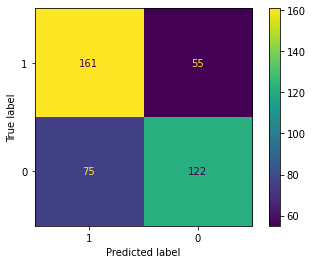

C:\Users\lukep\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


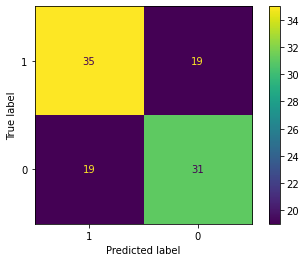

In [45]:
matrizConfusion_train_KNN = obtenerMatrizConfusion(bsKNN,X_train,y_train)
matrizConfusion_test_KNN = obtenerMatrizConfusion(bsKNN,X_test,y_test)

In [46]:
y_pred = bsKNN.predict(X_train)
target_names = ['class 0', 'class 1']
print(metrics.classification_report(y_train,y_pred, target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.69      0.62      0.65       197
     class 1       0.68      0.75      0.71       216

    accuracy                           0.69       413
   macro avg       0.69      0.68      0.68       413
weighted avg       0.69      0.69      0.68       413



In [47]:
y_pred = bsKNN.predict(X_test)
target_names = ['class 0', 'class 1']
print(metrics.classification_report(y_test,y_pred, target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.62      0.62      0.62        50
     class 1       0.65      0.65      0.65        54

    accuracy                           0.63       104
   macro avg       0.63      0.63      0.63       104
weighted avg       0.63      0.63      0.63       104



Observamos que los valores de las diagonales tanto como para train y test son los más grandes, esto quiere decir que la mayoría de los ejemplos son clasificados correctamente. Además la precisión y el recall no son datos demasiado malos, son superiores a 0.5, que es lo que sería un clasificador aleatorio.

### Curva ROC

In [48]:
# Función que muestra la curva ROC para una lista de clasificadores (listaClfs) y unos datos de entrada (X) y salida (y)
    # labels son los nombres de los clasificadores utilizados
def muestra_ROC_courve(listaClfs, X, y, labels):
    # generamos una predicción sin calidad para la clase positiva (1): todas las predicciones con probabilidad 0      
    ns_probs = np.zeros(len(y))
    # calculamos el área bajo la curva ROC (método roc_auc_score pasando las clases reales y las probabilidades de la clase positiva)
        # En tanto por 100
    ns_auc = metrics.roc_curve(y, ns_probs)*100
    # calculamos todos los pares de puntos (fpr, tpr) para dibujar la curva ROC (método roc_curve pasando las clases reales y las probabilidades de la clase positiva)
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y,ns_probs)
    
    # Lista para almacenar los AUC bajo la curva ROC de los clasificadores
    listaAUCs = []
    # Para cada clasificador de la lista
    for i,clf in enumerate(listaClfs):
        # predecimos las probabilidades de predecir cada ejemplo en cada clase en base al método que implemente el clasificador
        if hasattr(clf, 'predict_proba'):
            # Si el clasificador implementa predict_proba nos quedamos con las predicciones de la clase positiva (1)
            model_probs = clf.predict_proba(X)[:,1]
        else:
            # Si el clasificador implementa decision_function
            model_probs = clf.decision_function(X)

        # calculamos todos los pares de puntos (fpr, tpr) para dibujar la curva ROC (método roc_curve pasando las clases reales y las probabilidades de la clase positiva)
        model_fpr, model_tpr, _ = metrics.roc_curve(y,model_probs)
        # calculamos el área bajo la curva ROC, y lo añadimos a la lista de rendimiento, en tanto por 100
        model_auc = metrics.auc(model_fpr,model_tpr)*100
        listaAUCs.append(model_auc) 
        # Mostramos visualmente la curva ROC (plot mostrando fpr en el eje x y tpr en el eje y) poniendo como etiqueta el nombre del clasificador
        # <RELLENAR>
        plt.plot(model_fpr,model_tpr)
        
    # mostramos la curva del modelo sin calidad
    # <RELLENAR>
    plt.plot(ns_fpr,ns_tpr)
    # Etiquetamos los ejes
    # <RELLENAR>
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    # Creamos la leyenda de la figura
    # <RELLENAR>
    plt.legend([labels[0],'sin calidad'])
    # Ponemos título a la figura
    # <RELLENAR>
    plt.title('Curva ROC')
    # Mostramos la figura
    # <RELLENAR>
    plt.show()
    # Devolvemos la lista con los AUC de los diferentes clasificadores
    # <RELLENAR>
    return listaAUCs

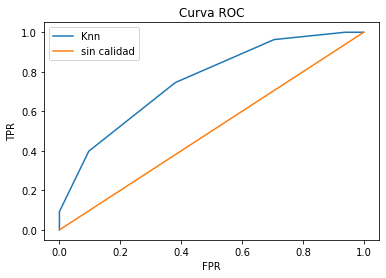

In [49]:
listaAUCs = muestra_ROC_courve([bsKNN], X_train, y_train, ['Knn'])

Podemos ver con la curva ROC mejora las predicciones de un clasificador aleatorio.

   ## Seleccion de instancias: COMPROBAMOS QUE NO MEJORAN NUESTRO MODELO. No lo hemos acabado implementandolo  

In [50]:
def leaveOneOut(clasificador, X, y):
    """
    :param clasificador: Instancia de un clasificador de Scikit-Learn entrenada (con fit hecho con los datos de train o el subconjunto seleccionado)
    :param X: Matriz con los ejemplos de entrenamiento completo (para hacer leave one out)
    :param y: Vector con la salida de los ejemplos de entrenamiento completo (correspondientes a X)
    :return: Vector con la salida obtenida para cada ejemplo de X (siguiendo el esquema leave-one-out)
    """
    # En caso de que el clasificador no sea KNN simplemente se utiliza el clasificador aprendido y se predicen los ejemplos con dicho clasificador
    if type(clasificador) != KNeighborsClassifier:
        # Utiliza el método predict para obtener la predicción
        prediction = clasificador.predict(X)
        return prediction
    
    # En otro caso será una instancia de KNeighborsClassifier
    # kneighbors nos devuelve los vecinos más cercanos de cada ejemplo en X y las distancias asociadas
        # distancias y vecinos serán matrices de numEjemplos x k+1 elementos
    distancias, vecinos = clasificador.kneighbors(X, n_neighbors=clasificador.n_neighbors + 1, return_distance=True)
    # Realmente no estamos interesados en el propio vecino, sino en la clase a la que pertenece
    # Transformamos los vecinos a una matriz con la clase de cada vecino
    # Accedemos a las clases de los ejemplos de entrenamiento (atributo _y del clasificador knn) 
        # y cogemos los elementos en las posiciones de los vecinos calculados anteriormente
    vecinosClase = clasificador._y[vecinos]
    
    # Ahora queda decidir la clase de salida para cada uno de los ejemplos
    # Debemos tener en cuenta: Si la distancia al primer vecino es 0, el vecino es el propio ejemplo y por tanto no lo usamos para decidir
    #   1. Obtenemos una máscara con los ejemplos en los que ocurre esto
    #   2. Sustituimos la clase del primer vecino por la del último (el k+1 que sino no se utiliza)
    #   3. Obtenemos la moda (stats.mode) (el valor más repetido de clase) para cada fila (cogiendo los k primeros valores)
    mascara =  distancias[:,0] == 0
    vecinosClase[mascara,0] =  vecinosClase[mascara,-1]
    prediction,_ =  stats.mode(vecinosClase[:,:-1],axis = 1)
    

    return prediction

In [51]:
def ENN(X, y, k=3):
    """
    Algoritmo ENN para la selección de instancias. Cada ejemplo se elimina si se clasifica incorrectamente por sus k vecinos más cercanos
    :param X: Matriz con los ejemplos de entrenamiento (se asume que los ejemplos están normalizados)
    :param y: Vector con la salida de los ejemplos en X
    :param k: Valor de k a utilizar en ENN
    :return: Vector con la máscara de instancias seleccionadas 
            (La posición S[i]=True indica que la instancia i ha sido seleccionada y False lo contrario)
    """
    # S es una máscara de booleanos que indica si el ejemplo en la posición i está seleccionado (True) o no lo está (False)
    # inicialmente todos los índices/instancias son seleccionadas
    S =  np.ones(X.shape[0], dtype=bool)

    # Creamos el clasificador knn con el valor de k dado
    knn = KNeighborsClassifier(k)

    # Para cada ejemplo, comprobamos si este es fallado al ser clasificado por sus k vecinos más cercanos (sin contar a sí mismo)
    for i in range(0, X.shape[0]):
        # Eliminamos el ejemplo de la selección para no tenerlo en cuenta al clasificarlo: modificar la máscara
        # <RELLENAR>
        S[i] = False
        # Entrenamos knn con el conjunto de instancias seleccionadas actualmente
        # <RELLENAR>
        knn.fit(X[S,:],y[S])
        # Si la instancia es correctamente clasificada restauramos su valor en la máscara
        # <RELLENAR>
        prediction = knn.predict(X[i,:].reshape(1,-1))
        if(prediction == y[i]):
            S[i] = True
        
    return S

In [52]:
def ejecutaMetodoIS(funcionMetodo, clasificador, X_train, y_train, X_test, y_test, verbose=True):
    """
    Esta función se encajar de ejecutar un método de selección de instancias y dar los resultados sobre train y test
    con el clasificador introducido como parámetro
    :param funcionMetodo: Función con el método de selección de instancias a ejecutar
    :param clasificador: Instancia del clasificador a utilizar para obtener la precisión en train y test
    :params X_train e y_train: Conjunto de datos de entrada y salida de los datos de entrenamiento
    :params X_test e y_test: Conjunto de datos de entrada y salida de los datos de test
    :return: tupla con la máscara de ejemplos seleccionados, la precisión en train, precisión en test y porcentaje de reducción obtenido
    """
    # Obtenemos el nombre del método. Como es una función utilizamos su campo __name__
    nombreMetodo = funcionMetodo.__name__
    if verbose:
        print ("Ejecutando " + nombreMetodo + "...")
    # Ejecutamos el método de selección de instancias correspondiente con los ejemplos de entrenamiento y sus clases
        # Utilizad todos los métodos con los parámetros por defecto y almacenad la máscara devuelta en una variable llamada S
    # <RELLENAR>
    S = funcionMetodo(X_train,y_train)
    # Entrenamos el clasificador correspondiente solo con los ejemplos seleccionados (aplicamos la máscara S)
    # <RELLENAR>
    clasificador = clasificador.fit(X_train[S,:],y_train[S])
#     # Obtenemos las salidas para train mediante leaveOneOut
    predictionTrain = leaveOneOut(clasificador,X_train,y_train)
#     # Obtenemos la precisión en train con las salidas obtenidas (tanto por uno)
    accTrain =metrics.accuracy_score(y_train,predictionTrain)
#     # Obtenemos las salidas para test 
    predictionTest = clasificador.predict(X_test)
    
    # Obtenemos la precisión en test  (tanto por uno)
    accTest = metrics.accuracy_score(y_test,predictionTest)
    # Calculamos el porcentaje de reducción
    reduction = (1-(S.sum())/S.size)*100
        
    
    if verbose:
#         print("Dataset " + dataset)
        print("Resultados " + nombreMetodo + " python")
        print("Precisión en train: {}".format(accTrain))
        print("Precisión en test: {}".format(accTest))
        print("Reducción " + nombreMetodo + ": {} de {}".format(S.sum(), S.size))
        print("Reducción: %2.2f%%" % reduction)
        # En caso de ser un árbol, imprimimos el número de reglas obtenidas
        if type(clasificador) == tree.DecisionTreeClassifier:
            print("Número de reglas: {}".format(clasificador.tree_.node_count))

    # Mostramos los resultados obtenidos por el método gráficamente
#     mostrar(clasificador, X_train, y_train, X_test, y_test,  nombreMetodo, X_train[S, :], y_train[S])

    # Si es un árbol, devolvemos el número de reglas obtenidas
    nReglas = -1
    if type(clasificador) == tree.DecisionTreeClassifier:
        nReglas = clasificador.tree_.node_count
    return S, accTrain, accTest, reduction, nReglas

In [53]:
def CNN(X, y, k=1):
    """
    Algoritmo CNN para la selección de instancias. Se comienza con dos ejemplos aleatorios (uno de cada clase) y cada ejemplo
    que se falla al ser clasificado por los ya seleccionados se añade a la selección (se para cuando ya no se añaden más ejemplos)
    :param X: Matriz con los ejemplos de entrenamiento (se asume que los ejemplos están normalizados)
    :param y: Vector con la salida de los ejemplos en X
    :param k: Valor de k a utilizar en CNN
    :return: Vector con la máscara de instancias seleccionadas 
            (La posición S[i]=True indica que la instancia i ha sido seleccionada y False lo contrario)
    """
    # Como usamos aleatorios en CNN establecemos la semilla para que el test sea correcto y siempre obtengamos el mismo resultado
    np.random.seed(12312)
    # Creamos el clasificador knn con el valor de k dado
    knn = KNeighborsClassifier(k)
    # S es una máscara de booleanos que indica si el ejemplo en la posición i está seleccionado (True) o no lo está (False)
    S = np.array(([False]*X.shape[0]))


    # Inicialmente, seleccionamos aleatoriamente una instancia de cada clase
    # Anotamos el número de clases
    nClases = np.unique(y)
    # Para cada clase, buscamos los índices de los ejemplos de dicha clase y seleccionamos uno de ellos aleatoriamente
    # Dicho ejemplo coge el valor True en S
    for c in nClases:
        indicesClase = np.where(y == c)[0]  # np.where devuelve una tupla, nos interesa la primera parte que contiene los índices de las posiciones que no son 0 o False
        # Elegid una instancia aleatoriamente de las de la clase: utilizad randint de Numpy para ello
        instanciaAleatoria = indicesClase[np.random.randint(len(indicesClase))]
        # Modificad la máscara S de acuerdo a la instancia seleccionada
        # <RELLENAR>
        S[instanciaAleatoria] = True
    # Solo evaluamos los ejemplos que no están en S (los que están se aciertan por definición al considerlos
    # como vecinos de sí mismos). Estos ejemplos son los únicos que podemos añadir a S
    notS = S == False

    # "Entrenamos" knn con los ejemplos seleccionados
    knn = knn.fit(X[S,:], y[S])

    # Inicializamos el número de fallados para entrar en el bucle. El algoritmo termina cuando no se fallan ejemplos
    fallados = -1
    while fallados != 0:
        # Ponemos el contador de fallados a 0 y comprobamos todos los ejemplos no seleccionados
        fallados = 0
        # Obtenemos los índices de los ejemplos no seleccionados: utilizad np.where como se ha hecho anteriormente
        indices = np.where(notS)[0]
        # Para cada ejemplo no seleccionado (y en orden aleatorio) comprobamos si dicho ejemplo se falla         
        # con las instancias en S actualmente. Si se falla, el ejemplo se añade a S, se reentrena KNN y se suma uno a fallados
        for i in np.random.permutation(indices):
#           #<RELLENAR>
            prediction = knn.predict(X[i,:].reshape(1,-1))
            if(prediction != y[i]):
                S[i] = True
                knn = knn.fit(X[S,:], y[S])
                fallados += 1
            
        # Recalculamos los ejemplos a estudiar en la próxima iteración, aquellos no seleccionados
        notS = np.invert(S)
        
        print("CNN, fin de iteración, fallados: {}, ejemplos en S: {}".format(fallados, np.sum(S)))

    return S

In [54]:
def RMHC(X, y, s=0.1, iteraciones=1000, k=1):
    """
     Algoritmo RMHC (Random Mutation Hill Climbing) para la selección de instancias.
      Se comienza con una selección aleatoria de s * nEjemplos instancias. Para cada iteración, se elige una instancia
      seleccionada y una no seleccionada para ser intercambiadas. Si el intercambio mejora la precisión (leave-one-out) sobre train
      se mantiene el cambio, sino se deshace
    :param X: Matriz con los ejemplos de entrenamiento (se asume que los ejemplos están normalizados)
    :param y: Vector con la salida de los ejemplos en X
    :param s: Porcentaje de instancias a ser seleccionadas (s es un valor entre 0 y 1)
    :param iteraciones: Número de iteraciones (intercambios) a probar
    :param k: Valor de k a utilizar en RMHC
    :return: Vector con la máscara de instancias seleccionadas 
            (La posición S[i]=True indica que la instancia i ha sido seleccionada y False lo contrario)
    """
    # Como usamos aleatorios en RMHC establecemos la semilla para que el test sea correcto y siempre obtengamos el mismo resultado
    np.random.seed(12312)
    # Creamos el clasificador knn con el valor de k dado
    knn = KNeighborsClassifier(k)

    # En este caso vamos a mantener dos vectores de enteros con los índices de las instancias seleccionadas y no seleccionadas
    # Establecemos el número de instancias a seleccionar (es fijo)
    nSel = int(s * X.shape[0])
    # Obtenemos una permutación aleatoria de todos los índices disponibles 
    # (un array de 0 a X.shape[0] con valores ordenados aleatoriamente): utilizad permutation de Numpy
    permute = np.random.permutation(np.arange(0,X.shape[0]))
    # Cogemos como seleccionadas las instancias correspondientes a los primeros nSel índices  y no seleccionadas el resto
    seleccionadas = permute[:nSel]
    noSeleccionadas = permute[nSel:]

    # Calculamos la preicisión con la selección inicial
    # Entrenamos KNN con las instancias seleccionadas
    # <RELLENAR>
    knn = knn.fit(X[seleccionadas],y[seleccionadas])
    # Obtenemos las salidas con leaveOneOut (para no tener en cuenta las instancias seleccionadas como vecinos de sí mismas)
    salidas = leaveOneOut(knn, X, y)

    # Calculamos la precisión
    acc = metrics.accuracy_score(salidas,y)

    # Comenzamos las iteraciones:
    #   En cada una, intercambiamos una instancia seleccionada con una que no lo está y comprobamos si mejora la precisión
    for i in range(0, iteraciones):
        # Seleccionamos un índice de manera aleatoria que nos indica la instancia a eliminar de las seleccionadas: randint de Numpy
        quitar = np.random.randint(len(seleccionadas))
        # Seleccionamos un índice de manera aleatoria que nos indica la instancia a añadir a las seleccionadas: randint de Numpy
        poner = np.random.randint(len(noSeleccionadas))
        # Guardamos el ejemplo eliminado
        aux = seleccionadas[quitar]
        # Añadimos la nueva instancia seleccionada sustituyendo la que se elimina: intercambio en las listas de seleccionados y no seleccionados
        # <RELLENAR>
        seleccionadas[quitar] = noSeleccionadas[poner]
        noSeleccionadas[poner] = aux
        # Entrenamos de nuevo kNN
        knn = knn.fit(X[seleccionadas], y[seleccionadas])
        
        # Calculamos la precisión de la solución actual
        # Obtenemos las salidas con leaveOneOut (para no tener en cuenta las instancias seleccionadas como vecinos de sí mismas)
        salidas = leaveOneOut(knn, X, y)
        # Calculamos la precisión
        accNew = metrics.accuracy_score(salidas,y)

        # Si la precisión actual es peor que la anterior, devolvemos la instancia eliminada a las seleccionadas
        # Sino si la precisión de la solución actual es mejor o igual que la anterior, guardamos la precisión y
        #  añadimos la instancia eliminada a las no seleccionadas
        # <RELLENAR>
        if(accNew < acc):
            noSeleccionadas[poner] = seleccionadas[quitar]
            seleccionadas[quitar] = aux
        else:
            acc = accNew

        if i % 100 == 0:
            print("precision en iteracion {}: {}".format(i, acc))

    # A partir de las seleccionadas creamos la máscara de instancias seleccionadas 
    # donde True en la posición i indica que la instancia i es seleccionada
    S = np.array(([False]*X.shape[0]))
    S[seleccionadas] = True

    return S

In [55]:
def sinSeleccion(X, y):
    S = np.array(([True]*X.shape[0]))
    return S

## Comparación métodos knn

In [56]:
# Establecemos una lista con las funciones de los métodos de selección incluyendo el de no hacer selección
metodos = (sinSeleccion, ENN, CNN, RMHC)
# Obtenemos el número de métodos 
nMetodos =len(metodos)

# Inicializamos las variables para guardar los resultados
S = np.zeros((nMetodos, X_train.shape[0]))
accTrain = np.zeros((nMetodos))
accTest = np.zeros((nMetodos))
reduction = np.zeros((nMetodos))
for i, metodo in enumerate(metodos):
    # Ejecutamos cada método con knn y los conjuntos de train y test de iris, ponemos verbose=False
    S[i, :], accTrain[i], accTest[i], reduction[i], _ = ejecutaMetodoIS(metodo, knn, X_train, y_train.ravel(), X_test, y_test.ravel(), verbose=True)

Ejecutando sinSeleccion...
Resultados sinSeleccion python
Precisión en train: 0.5472154963680388
Precisión en test: 0.6346153846153846
Reducción sinSeleccion: 413 de 413
Reducción: 0.00%
Ejecutando ENN...
Resultados ENN python
Precisión en train: 0.6271186440677966
Precisión en test: 0.5961538461538461
Reducción ENN: 254 de 413
Reducción: 38.50%
Ejecutando CNN...
CNN, fin de iteración, fallados: 195, ejemplos en S: 197
CNN, fin de iteración, fallados: 59, ejemplos en S: 256
CNN, fin de iteración, fallados: 11, ejemplos en S: 267
CNN, fin de iteración, fallados: 0, ejemplos en S: 267
Resultados CNN python
Precisión en train: 0.4891041162227603
Precisión en test: 0.5480769230769231
Reducción CNN: 267 de 413
Reducción: 35.35%
Ejecutando RMHC...
precision en iteracion 0: 0.5108958837772397
precision en iteracion 100: 0.6368038740920097
precision en iteracion 200: 0.6658595641646489
precision en iteracion 300: 0.6949152542372882
precision en iteracion 400: 0.7021791767554479
precision en it

## Comparación métodos arboles de decisión

In [57]:
metodos = (sinSeleccion, ENN, CNN, RMHC)
# Obtenemos el número de métodos 
nMetodos =len(metodos)
arbol = tree.DecisionTreeClassifier()
# Inicializamos las variables para guardar los resultados
S = np.zeros((nMetodos, X_train.shape[0]))
accTrain = np.zeros((nMetodos))
accTest = np.zeros((nMetodos))
reduction = np.zeros((nMetodos))
nRules = np.zeros((nMetodos))
for i, metodo in enumerate(metodos):
    # Ejecutamos cada método con knn y los conjuntos de train y test de iris, ponemos verbose=False
    arbol = tree.DecisionTreeClassifier(criterion='entropy', random_state=123)
    S[i, :], accTrain[i], accTest[i], reduction[i], nRules[i] = ejecutaMetodoIS(metodo, arbol, X_train, y_train.ravel(), X_test, y_test.ravel(), verbose=True)

Ejecutando sinSeleccion...
Resultados sinSeleccion python
Precisión en train: 0.9903147699757869
Precisión en test: 0.6346153846153846
Reducción sinSeleccion: 413 de 413
Reducción: 0.00%
Número de reglas: 231
Ejecutando ENN...
Resultados ENN python
Precisión en train: 0.738498789346247
Precisión en test: 0.5673076923076923
Reducción ENN: 254 de 413
Reducción: 38.50%
Número de reglas: 89
Ejecutando CNN...
CNN, fin de iteración, fallados: 195, ejemplos en S: 197
CNN, fin de iteración, fallados: 59, ejemplos en S: 256
CNN, fin de iteración, fallados: 11, ejemplos en S: 267
CNN, fin de iteración, fallados: 0, ejemplos en S: 267
Resultados CNN python
Precisión en train: 0.837772397094431
Precisión en test: 0.6153846153846154
Reducción CNN: 267 de 413
Reducción: 35.35%
Número de reglas: 193
Ejecutando RMHC...
precision en iteracion 0: 0.5108958837772397
precision en iteracion 100: 0.6368038740920097
precision en iteracion 200: 0.6658595641646489
precision en iteracion 300: 0.6949152542372882

## Conclusiones finales

En conclusión nuestro modelo elegido para la resolución del problema, que es filtro ANOVA usando knn con estos hiperparámetros: {'KNN__n_neighbors': 5, 'KNN__p': 3, 'KNN__weights': 'uniform'}.

No obtenemos unos accuracys muy altos debido a que las medidas son tomadas por la naturaleza por lo que no siguen una estructura lineal del todo predecible. Además nuestro dataset no es lo demasiado amplio para poder generalizar correctamente.